# RL solutions for combinatorial games: Temporal Difference Methods

**Refer [the notebook on Monte Carlo Control](nim_MC_on_policy.ipynb) for the problem set up**

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
np.random.seed(42)

In [3]:
# A Simple Nim Game
class SimpleNim:
    def __init__(self, state):
        self.heaps = state
        self.turn = 0
        self.num_heaps = len(self.heaps)

    def get_state(self):
        if isinstance(self.heaps, list):
            return tuple(self.heaps)
        else:
            return tuple(self.heaps.tolist())

    def get_num_heaps(self):
        return self.num_heaps

    def get_heap_size(self, heap_index):
        if 0 <= heap_index < self.num_heaps:
            return self.heaps[heap_index]
        return None

    def is_game_over(self):
        return all(pebbles == 0 for pebbles in self.heaps)

    def make_move(self, heap_index, num_pebbles):
        if self.is_game_over():
            return False

        # Validate the move
        if 0 <= heap_index < self.num_heaps and 0 < num_pebbles <= self.heaps[heap_index]:
            self.heaps[heap_index] -= num_pebbles
            self.turn = 1 - self.turn  # Switch turns
            return True
        return False

    def winner(self):
        if self.is_game_over():
            return 1-self.turn
        return None

In [4]:
def nim_sum(s):
    xor = 0
    for heap in s:
        xor ^= heap
    return xor

In [5]:
# Function to play the optimal move in Nim, end on a zero nim-sum
def play_optimal(game):
    if game.is_game_over():
        return None

    nim_sum_value = nim_sum(game.get_state())
    heaps = game.get_state()
    for i in range(game.get_num_heaps()):
        if heaps[i] > 0 and (nim_sum_value ^ heaps[i]) < heaps[i]:
            # Make the move that results in a zero nim-sum
            game.make_move(i, heaps[i] - (nim_sum_value ^ heaps[i]))
            return True
    # If no optimal move is found
    index = np.random.randint(0, game.get_num_heaps())
    while game.get_heap_size(index) == 0:
        index = np.random.randint(0, game.get_num_heaps())
    game.make_move(index, 1)

In [6]:
def play_random(game):
    if game.is_game_over():
        return
    heaps = game.get_state()

    index = np.random.randint(0, len(heaps))
    while heaps[index] == 0:
        index = np.random.randint(0, len(heaps))

    num_pebbles = np.random.randint(1, heaps[index] + 1)
    game.make_move(index, num_pebbles)

In [7]:
# opponent that plays optimal with probability prob_optimal
def play_optimal_random(game, prob_optimal=1.0):
    random_choice = np.random.rand()
    if random_choice < prob_optimal:
        play_optimal(game)
    else:
        play_random(game)

In [8]:
# simple simulation of a nim game with both players using the optimal strategy
heaps = [10] * 3
game = SimpleNim(heaps)
while not game.is_game_over():
    play_optimal(game)
    print(game.get_state())
print("The winner is Player ", game.winner())

(0, 10, 10)
(0, 10, 9)
(0, 9, 9)
(0, 9, 8)
(0, 8, 8)
(0, 8, 7)
(0, 7, 7)
(0, 7, 6)
(0, 6, 6)
(0, 5, 6)
(0, 5, 5)
(0, 5, 4)
(0, 4, 4)
(0, 4, 3)
(0, 3, 3)
(0, 3, 2)
(0, 2, 2)
(0, 2, 1)
(0, 1, 1)
(0, 1, 0)
(0, 0, 0)
The winner is Player  0


## Defining State and Action Spaces:
**The State** is given by a configuration of heaps($\N_0$ means the set of naturals that includes zero):
$$ \mathcal S = \N_0^h $$
where h is the number of heaps
**Actions** are given by two tuples of heap number and number of pebbles to be taken out:
$$ \mathcal A(s) = H(s) \times \N $$ 
where $\N$ does not include zero and $H(s)$ is the set of heaps having non zero number of pebbles in the state s

In [9]:
# helper function that evaluates a policy based on whether the turn ends on a nim sum of 0
def is_optimal(s, a):
    s = list(s)
    if a[1] == 0: return False
    s[a[0]] -= a[1]
    return nim_sum(s) == 0

In [10]:
# for simplicity consider the version of the problem that starts off with same number of pebbles in each heap
num_heaps = 3
initial_pebbles = 5
max_episodes = 1000000

start_state = (initial_pebbles,) * num_heaps

In [11]:
# Defining a class for epsilon greedy policy that has methods to update epsilon to account for GLIE conditions and to sample from epsilon greedy policy
class EpsilonGreedyPolicy:
    def __init__(self):
        self.epsilon = 1

    def update(self, epsilon):
        self.epsilon = epsilon

    def policy(self, s, Q):
        if s not in Q or np.random.random() < self.epsilon:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        else:
            return max(Q[s], key=Q[s].get)

    # Returns a policy that does not explore
    def final_policy(self, s, Q):
        if s not in Q or len(Q[s]) == 0:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [12]:
class SimpleGreedyPolicy:
    def update(self, epsilon): pass

    def policy(self, s, Q):
        if s not in Q:
            index = np.random.randint(0, len(s))
            while s[index] == 0:
                index = np.random.randint(0, len(s))
            return (index, 1)
        return max(Q[s], key=Q[s].get)

    def final_policy(self, s, Q):
        if s not in Q:
            return (0,0)
        return max(Q[s], key=Q[s].get)

In [13]:
def sample_step_reward_zero_on_loss(game, A, prob_optimal=1.0):
    game.make_move(A[0],A[1])
    play_optimal_random(game, prob_optimal)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    else: return 0, S_next

### SARSA: On policy TD(0)

SARSA (State-Action-Reward-State-Action) is an on-policy temporal-difference (TD) learning algorithm used to estimate the action-value function $Q(s, a)$ using Bootstrapping i.e. it makes use of an estimate of $Q(s, a)$(a guess) to update our current estimate of $Q(s, a)$(another guess) for a particular state-action pair using a sample reward over one step.

Bootstrapping basically refers to how we are using a guess to update another guess using some experience information.

The update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma Q(s_{t+1}, a_{t+1}) - Q(s_t, a_t) \right]
$$

Here:

* $\alpha$ is the learning rate,
* $\gamma$ is the discount factor,
* $(s_t, a_t, r_{t+1}, s_{t+1}, a_{t+1})$ is the observed transition following the current policy.

In [33]:
# SARSA
def sarsa(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, prob_optimal=1.0, epsilon_schedule_update=None):
    Q = {} # take default to be zero

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    if epsilon_schedule is None and epsilon_schedule_update is None:
        policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]
            Q[S][A] = Q[S][A] + step_size*delta

            A = A1
            S = S1

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])
        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history

In [14]:
import itertools

def evaluate_on_winning_positions(policy, Q):
    fumbles = 0
    num_winning_pos = 0
    for s in itertools.product(range(initial_pebbles), repeat=num_heaps):
        if s == (0)*num_heaps: continue
        action = policy.final_policy(s, Q)
        if nim_sum(s) == 0: continue
        if not is_optimal(s, action):
            fumbles+=1
        num_winning_pos+=1
    return fumbles, num_winning_pos

In [15]:
def evaluate_using_fumbles(policy, Q):
    fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
    print('number of fumbles:', fumbles)
    print('total number of winning positions:', num_winning_pos)
    print('percentage of winning positions fumbled: {:.2f} %'.format(fumbles/num_winning_pos*100))

In [34]:
# Epsilon Greedy and exploring starts
policy, Q, history = sarsa()

print(Q[start_state] if start_state in Q else "No Q-values for start state")
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:20<00:00, 49904.69it/s]

Q values at start state: {(2, 1): 0.0, (0, 5): 0.8874481058332433, (2, 4): 0.0, (1, 1): 0.0, (2, 2): 0.0, (1, 5): 0.8792125738808185, (0, 4): 0.0, (2, 5): 0.9139230012692195, (1, 3): 0.0, (0, 2): 0.0, (2, 3): 0.0, (1, 2): 0.0, (0, 3): 0.0, (1, 4): 0.0, (0, 1): 0.0}
{(2, 1): 0.0, (0, 5): 0.8874481058332433, (2, 4): 0.0, (1, 1): 0.0, (2, 2): 0.0, (1, 5): 0.8792125738808185, (0, 4): 0.0, (2, 5): 0.9139230012692195, (1, 3): 0.0, (0, 2): 0.0, (2, 3): 0.0, (1, 2): 0.0, (0, 3): 0.0, (1, 4): 0.0, (0, 1): 0.0}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


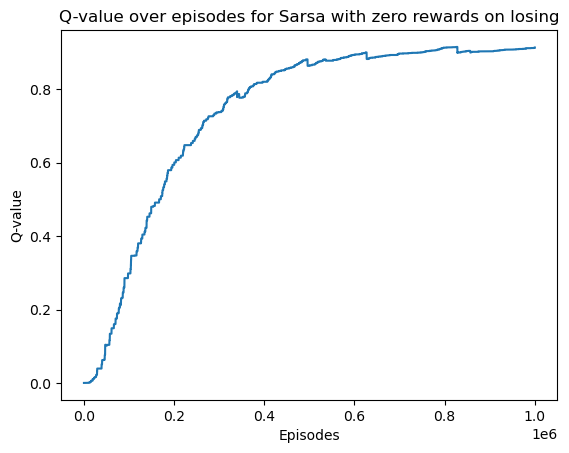

In [35]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa with zero rewards on losing')
plt.show()

In [36]:
# Epsilon Greedy but no exploring starts
policy, Q, history = sarsa(exploring_starts=False)

print(Q[start_state])
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:18<00:00, 55223.71it/s]

Q values at start state: {(2, 1): 0.0, (1, 1): 0.0, (0, 1): 0.0}
{(2, 1): 0.0, (1, 1): 0.0, (0, 1): 0.0}
number of fumbles: 106
total number of winning positions: 106
percentage of winning positions fumbled: 100.00 %


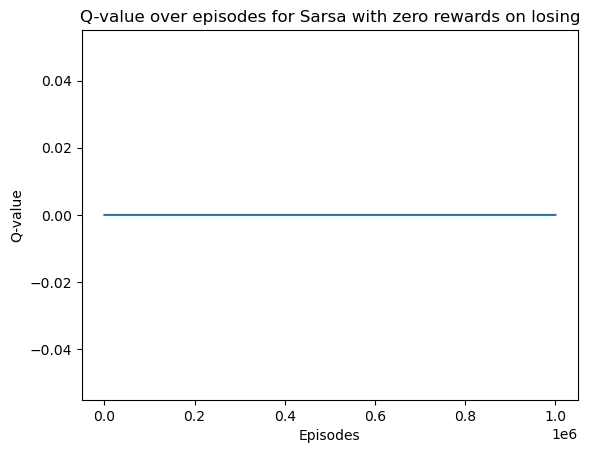

In [37]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa with zero rewards on losing')
plt.show()

In [16]:
# Apply the new rewards model with negative rewards for losses
def sample_step_reward_negative_on_loss(game, A, prob_optimal=1.0):
    game.make_move(A[0],A[1])
    play_optimal_random(game, prob_optimal=prob_optimal)
    S_next = game.get_state()
    if game.is_game_over() and game.winner() == 0: return 1, S_next
    elif game.is_game_over(): return -1, S_next
    else: return 0, S_next

In [177]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q, history = sarsa(exploring_starts=False, sample_step=sample_step_reward_negative_on_loss)

print(Q[start_state])
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:01<00:00, 76722.23it/s]

Q values at start state: {(0, 1): -0.9999999999999893, (2, 1): -0.9999999999999918, (1, 1): -0.9999999999999918}
{(0, 1): -0.9999999999999893, (2, 1): -0.9999999999999918, (1, 1): -0.9999999999999918}
number of fumbles: 20
total number of winning positions: 20
percentage of winning positions fumbled: 100.00 %


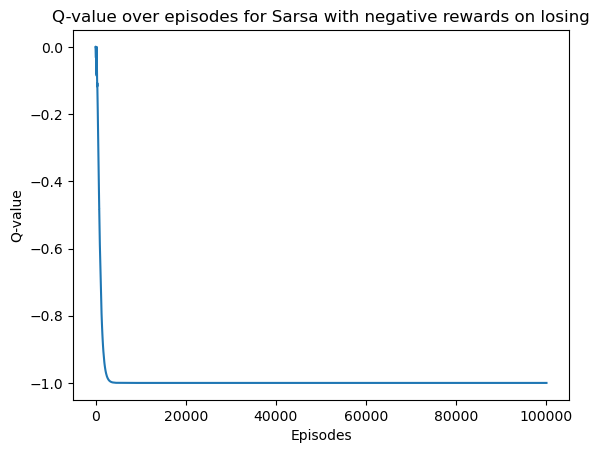

In [178]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa with negative rewards on losing')
plt.show()

In [38]:
# Epsilon Greedy with exploring starts negative rewards on losing
policy, Q, history = sarsa(sample_step=sample_step_reward_negative_on_loss)

print(Q[start_state])
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:20<00:00, 49056.99it/s]

Q values at start state: {(0, 2): -0.9966402790096188, (2, 3): -0.9973833834336637, (2, 4): -0.9952778726978703, (1, 5): 0.8404727328818624, (2, 1): -0.9973774578474865, (1, 2): -0.9977896465062003, (1, 3): -0.9962167326002807, (1, 1): -0.9976349285191192, (0, 1): -0.9977306987119561, (2, 5): 0.7799461250782133, (0, 3): -0.9967518630972345, (0, 5): 0.8391381078713306, (1, 4): -0.9975567347422463, (2, 2): -0.9983132921408625, (0, 4): -0.9962533099957825}
{(0, 2): -0.9966402790096188, (2, 3): -0.9973833834336637, (2, 4): -0.9952778726978703, (1, 5): 0.8404727328818624, (2, 1): -0.9973774578474865, (1, 2): -0.9977896465062003, (1, 3): -0.9962167326002807, (1, 1): -0.9976349285191192, (0, 1): -0.9977306987119561, (2, 5): 0.7799461250782133, (0, 3): -0.9967518630972345, (0, 5): 0.8391381078713306, (1, 4): -0.9975567347422463, (2, 2): -0.9983132921408625, (0, 4): -0.9962533099957825}
number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


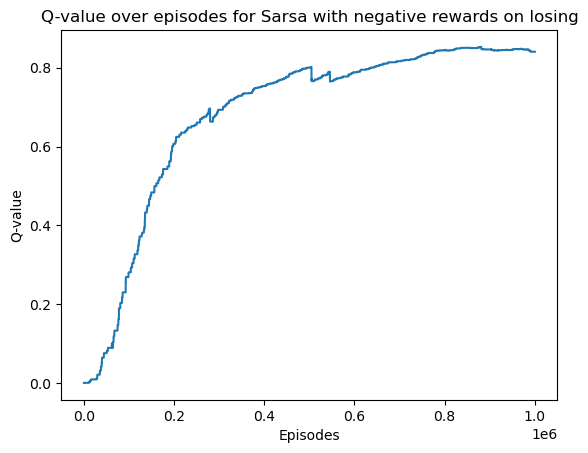

In [39]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa with negative rewards on losing')
plt.show()

In [17]:
# providing a way to check performance more reliably
def evaluate_using_fumbles_averaged(train, num_iters=5, prob_optimal=None, sample_step=sample_step_reward_negative_on_loss, play_against_optimal_until=None, epsilon_schedule=None, epsilon_schedule_update=None):
    num_winning_pos = 0
    total_fumbles = 0
    for i in range(num_iters):
        print(f'iteration {i+1}')
        if prob_optimal is None:
            if play_against_optimal_until is not None:
                policy, Q, history = train(sample_step=sample_step, play_against_optimal_until=play_against_optimal_until, epsilon_schedule=epsilon_schedule, epsilon_schedule_update=epsilon_schedule_update)
            else:
                policy, Q, history = train(sample_step=sample_step, epsilon_schedule=epsilon_schedule, epsilon_schedule_update=epsilon_schedule_update)
        else:
            policy, Q, history = train(sample_step=sample_step, prob_optimal=prob_optimal, epsilon_schedule=epsilon_schedule, epsilon_schedule_update=epsilon_schedule_update)

        fumbles, num_winning_pos = evaluate_on_winning_positions(policy, Q)
        total_fumbles += fumbles
    return total_fumbles, num_winning_pos

In [182]:
# num_iters = 5
# total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa, num_iters=num_iters)
# print('average number of fumbles: ', total_fumbles/num_iters)
# print('fumble rate: {:.2f}%'.format(total_fumbles/float(num_winning_pos*num_iters)*100))

### Q-learning: Off-policy TD(0) Control

Q-learning is an off-policy temporal-difference (TD) algorithm used to learn the optimal action-value function $Q^*(s, a)$, independent of the agent's behavior policy. It uses the maximum estimated value of the next state to update the current Q-value, allowing it to learn the optimal policy even while following a non-optimal (e.g. $\epsilon$-greedy) policy.

The update rule is:

$$
Q(s_t, a_t) \leftarrow Q(s_t, a_t) + \alpha \left[ r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a) - Q(s_t, a_t) \right]
$$

Here:

* $\alpha$ is the learning rate,
* $\gamma$ is the discount factor,
* $r_{t+1} + \gamma \max_{a} Q(s_{t+1}, a)$ is called the target
* The update targets the best possible next action, not necessarily the one actually taken.

**How is this different from SARSA?**  
The update rule looks very similar to SARSA but there is a subtle but very important difference.
- The difference lies in the target, specifically in the action chosen for the Q-value.
- The action is the one that is greedy with respect to the Q-function. This means that this action is chosen to be the greedy action no matter what the policy dictates.
- This property of Q-learning is what makes it an **Off-policy** method because the target doesn't depend on the current policy which means that the policy used for exploration(updating the Q-values) need not be the same as that which is used for control, while SARSA targets have actions chosen according to the current policy.

In [ ]:
# Q-Learning
def qlearning(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, epsilon_schedule_update=None, step_size_schedule=None, prob_optimal=1.0):
    Q = {} # take default to be zero

    Q_history = []  # To keep track of the initial Q-values

    if epsilon_schedule_update is None and epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal=prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}

            if len(Q[S1]) != 0: Q_max = Q[S1][max(Q[S1])]
            else: Q_max = 0

            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q_max
            delta = target-Q[S][A]
            current_step_size = step_size_schedule[i] if step_size_schedule is not None else step_size
            Q[S][A] += current_step_size*delta

            A = A1
            S = game.get_state()

        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        if epsilon_schedule is not None: policy.update(epsilon_schedule[i])

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history

In [31]:
policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss)

print(Q[start_state])

100%|██████████| 1000000/1000000 [00:19<00:00, 50323.73it/s]

Q values at start state: {(1, 5): -0.9958441307976733, (0, 2): -0.9968199076923571, (1, 1): -0.9967066891418815, (0, 5): -0.9979638112681449, (2, 4): -0.9954610010624506, (0, 1): -0.9974325282458762, (2, 1): -0.9975785666659797, (0, 3): -0.996849734095805, (2, 3): -0.9958052828131361, (2, 2): -0.9966456871607611, (1, 2): -0.996411953067578, (1, 4): -0.9973245097534411, (2, 5): -0.997517110326467, (1, 3): -0.9969930920426877, (0, 4): -0.9970602726710047}
{(1, 5): -0.9958441307976733, (0, 2): -0.9968199076923571, (1, 1): -0.9967066891418815, (0, 5): -0.9979638112681449, (2, 4): -0.9954610010624506, (0, 1): -0.9974325282458762, (2, 1): -0.9975785666659797, (0, 3): -0.996849734095805, (2, 3): -0.9958052828131361, (2, 2): -0.9966456871607611, (1, 2): -0.996411953067578, (1, 4): -0.9973245097534411, (2, 5): -0.997517110326467, (1, 3): -0.9969930920426877, (0, 4): -0.9970602726710047}


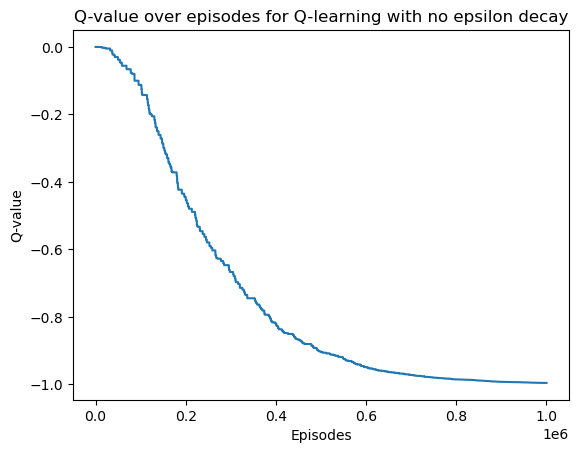

In [32]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with no epsilon decay')
plt.show()

In [40]:
evaluate_using_fumbles(policy, Q)

number of fumbles: 0
total number of winning positions: 106
percentage of winning positions fumbled: 0.00 %


In [42]:
def simplest_schedule(policy, i):
    policy.update(1.0/(i+1))

In [43]:
policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, epsilon_schedule_update=simplest_schedule)
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:19<00:00, 50386.12it/s]

Q values at start state: {(0, 1): -0.9961550542516256, (2, 1): -0.9974743772836608, (1, 3): -0.9966184492744462, (0, 5): -0.9959942588911623, (0, 3): -0.9964717099988598, (1, 1): -0.9970614557290097, (2, 5): -0.9974934838013992, (0, 4): -0.9950483721555899, (2, 4): -0.9987197651806474, (1, 2): -0.9968796574347547, (0, 2): -0.9959111280576848, (1, 4): -0.9969630265722288, (1, 5): -0.9950271810224809, (2, 3): -0.9959469971896231, (2, 2): -0.9925578758775699}
number of fumbles: 28
total number of winning positions: 106
percentage of winning positions fumbled: 26.42 %


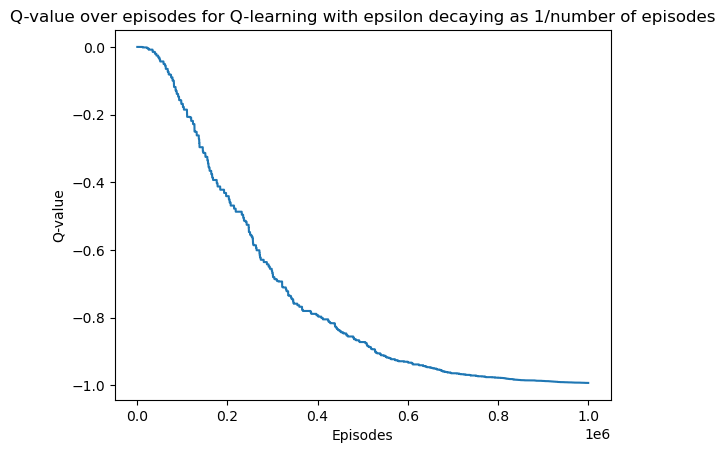

In [44]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with epsilon decaying as 1/number of episodes')
plt.show()

In [23]:
def get_geometric_schedule(decay):
    epsilon_schedule = []
    for i in range(max_episodes):
        epsilon_schedule.append((1-decay)*(decay**i))
    return epsilon_schedule

In [191]:
policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=get_geometric_schedule(decay=0.7))
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:01<00:00, 58409.88it/s]

Q values at start state: {(1, 1): -0.9274044687455885, (2, 2): -0.9471140590861075, (0, 3): -0.9439149855997079, (1, 2): -0.9400713243999653, (0, 1): -0.9436767072033396, (2, 3): -0.9597473249165238, (2, 1): -0.953141564073954, (1, 3): -0.9496906664631075, (0, 2): -0.9446835666547815}
number of fumbles: 3
total number of winning positions: 20
percentage of winning positions fumbled: 15.00 %


In [192]:
fumble_rate_by_decay = []
decays = np.linspace(0.1, 0.9, 9)

for decay in decays:
    print(f'decay: {decay}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters)

    fumble_rate_by_decay.append(float(total_fumbles)/float(num_winning_pos*num_iters))

decay: 0.1
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 56853.29it/s]


Q values at start state: {(0, 2): -0.9465090036826227, (2, 1): -0.9342875346729781, (2, 3): -0.9247353148062176, (1, 1): -0.9340588445672406, (2, 2): -0.9548701394285368, (0, 1): -0.9222304928351741, (1, 3): -0.9524465438808332, (0, 3): -0.9376188488337435, (1, 2): -0.9001966997198645}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 55828.46it/s]


Q values at start state: {(0, 2): -0.946842322119263, (2, 1): -0.9371176860212866, (0, 1): -0.9322751948754461, (1, 2): -0.9165250664405262, (2, 3): -0.9442636400054907, (2, 2): -0.9361866700077808, (1, 1): -0.9346603544927902, (1, 3): -0.9352312822564296, (0, 3): -0.9503139445252683}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 57119.18it/s]


Q values at start state: {(2, 2): -0.9361489826640471, (1, 2): -0.9282485691113207, (2, 1): -0.9179253172659473, (2, 3): -0.9621169313552453, (1, 3): -0.923429496552076, (0, 2): -0.938965017839986, (0, 1): -0.9383304589664352, (0, 3): -0.9345253598276031, (1, 1): -0.9411942377931617}
decay: 0.2
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 57029.72it/s]


Q values at start state: {(1, 1): -0.9042109115091006, (2, 2): -0.9475451182953475, (0, 2): -0.9385013449469918, (1, 3): -0.9384857793913508, (0, 3): -0.9614650263515409, (0, 1): -0.9247852685521011, (1, 2): -0.9466680277774928, (2, 3): -0.9408524784253315, (2, 1): -0.9439540237017803}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 57877.37it/s]


Q values at start state: {(1, 2): -0.9422919259618144, (0, 3): -0.947372322795346, (2, 1): -0.9333418638135009, (1, 3): -0.9596274877467547, (1, 1): -0.9413901861815268, (0, 1): -0.9304741074301722, (2, 2): -0.9600896553318251, (0, 2): -0.9286002360803548, (2, 3): -0.9277069218738212}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 58599.47it/s]


Q values at start state: {(0, 2): -0.9550929500868748, (1, 1): -0.932834403355962, (2, 3): -0.9491717410614493, (2, 1): -0.919700042821808, (0, 3): -0.9531681156361032, (1, 2): -0.9359865111324919, (0, 1): -0.9648143154569256, (1, 3): -0.939240672327376, (2, 2): -0.9503212722048936}
decay: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 58549.20it/s]


Q values at start state: {(2, 3): -0.9313180921929628, (1, 2): -0.9432619474654317, (0, 1): -0.8981168112112687, (1, 1): -0.931517247852437, (0, 2): -0.9258681915549651, (1, 3): -0.9405851524229503, (2, 1): -0.9426232360627139, (0, 3): -0.9491534162023897, (2, 2): -0.9585114048627073}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 58589.21it/s]


Q values at start state: {(2, 3): -0.9570089557365784, (1, 1): -0.9264943764504937, (0, 2): -0.9500071603366775, (0, 3): -0.9544828349527273, (0, 1): -0.9509503838168317, (2, 1): -0.9287559517628131, (1, 2): -0.932403343127308, (2, 2): -0.9681698370017273, (1, 3): -0.9326009658672241}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 58680.36it/s]


Q values at start state: {(2, 3): -0.9685881158289287, (1, 2): -0.9103543058053212, (0, 3): -0.9520887930817572, (0, 1): -0.931963789242678, (0, 2): -0.9311297755472266, (2, 2): -0.9627341675679331, (1, 3): -0.9477549727196056, (2, 1): -0.9286710842558135, (1, 1): -0.9339491163984645}
decay: 0.4
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 58957.32it/s]


Q values at start state: {(0, 1): -0.9436281067736482, (0, 2): -0.9184825846427119, (1, 3): -0.9569538017656348, (1, 1): -0.9371061005653244, (2, 1): -0.9459519089026228, (1, 2): -0.9226221357497405, (2, 3): -0.951995549231818, (2, 2): -0.9531586978293874, (0, 3): -0.9237823128710325}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 57873.50it/s]


Q values at start state: {(1, 2): -0.9210803008801117, (2, 1): -0.9345703797175333, (0, 2): -0.9491796931733273, (0, 1): -0.9532700878422461, (1, 3): -0.9281716891856341, (2, 3): -0.9185879034169513, (2, 2): -0.9567151632254918, (0, 3): -0.9579766261983328, (1, 1): -0.9413766296156454}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 59102.81it/s]


Q values at start state: {(1, 3): -0.956861258344365, (1, 2): -0.9454673724366579, (2, 3): -0.9351697699035333, (2, 1): -0.9493333245008603, (0, 2): -0.9264777356550784, (1, 1): -0.9501488810802717, (2, 2): -0.9329104597410628, (0, 3): -0.9341988386246379, (0, 1): -0.9098883165519442}
decay: 0.5
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 59280.76it/s]


Q values at start state: {(0, 2): -0.943200235834578, (1, 1): -0.923090879606893, (1, 3): -0.9482798973246065, (0, 1): -0.920936581890545, (2, 1): -0.9448544306245379, (1, 2): -0.9026802615443524, (2, 2): -0.9600462808892799, (2, 3): -0.9301090918140844, (0, 3): -0.9367882767237764}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 59304.81it/s]


Q values at start state: {(1, 1): -0.9339933716643556, (0, 1): -0.947225273718793, (0, 2): -0.9355404389605062, (1, 3): -0.9261691403262086, (0, 3): -0.9608366083745978, (2, 2): -0.9353484703221483, (2, 1): -0.9210780471750503, (2, 3): -0.9254440248999312, (1, 2): -0.9300526403291658}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 59145.06it/s]


Q values at start state: {(2, 3): -0.9345354785902459, (1, 3): -0.9476631183459808, (0, 1): -0.9481069008512609, (0, 2): -0.9156711952376473, (1, 2): -0.9378416186222229, (2, 1): -0.9354628669222986, (2, 2): -0.9339307467716899, (0, 3): -0.948902994005107, (1, 1): -0.9200644108263023}
decay: 0.6
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 59078.37it/s]


Q values at start state: {(0, 1): -0.945803803986388, (0, 3): -0.9485634290195545, (1, 1): -0.9213510902432988, (0, 2): -0.9477433018932372, (2, 3): -0.9206486245760152, (2, 2): -0.9440638995976773, (1, 3): -0.9515473060989579, (1, 2): -0.9311632317986298, (2, 1): -0.9447613685869867}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 59355.14it/s]


Q values at start state: {(2, 3): -0.957635389888944, (0, 2): -0.9206711209871523, (0, 3): -0.9380411209853, (2, 1): -0.9472019747767167, (1, 2): -0.9202966591043834, (2, 2): -0.9489590174098087, (1, 3): -0.9490723998282429, (1, 1): -0.9396427527153952, (0, 1): -0.9512869718085392}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 58345.44it/s]


Q values at start state: {(0, 2): -0.9377029164596306, (2, 3): -0.9440274967634361, (2, 2): -0.9527697673273446, (2, 1): -0.9355805432360381, (0, 1): -0.9237111908179954, (1, 2): -0.9267778546144059, (0, 3): -0.9462390151100927, (1, 3): -0.9563644452216123, (1, 1): -0.9381711207863154}
decay: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 57615.97it/s]


Q values at start state: {(2, 1): -0.8938843677337436, (2, 2): -0.9422556611735964, (1, 3): -0.9323660870741116, (2, 3): -0.948735052936758, (1, 1): -0.9253449470633559, (0, 2): -0.937695671024862, (1, 2): -0.8875487797297984, (0, 1): -0.9369940325903202, (0, 3): -0.9353193511042583}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 58875.31it/s]


Q values at start state: {(1, 2): -0.9182605458415176, (0, 3): -0.9557939655495437, (2, 2): -0.941413520447485, (0, 2): -0.9357786309174375, (0, 1): -0.9346619645597698, (2, 3): -0.9434994092171347, (1, 1): -0.9443488079200215, (1, 3): -0.9474059274492612, (2, 1): -0.9285957996159933}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 59324.02it/s]


Q values at start state: {(1, 3): -0.937624537629111, (2, 1): -0.9251249351458709, (1, 1): -0.9435087537811637, (0, 1): -0.9620648001798727, (2, 2): -0.9686088449622843, (2, 3): -0.9190698558408725, (0, 3): -0.9268856685274733, (0, 2): -0.9452187777406253, (1, 2): -0.947854321363417}
decay: 0.8
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 59077.04it/s]


Q values at start state: {(2, 2): -0.9781147577853108, (0, 3): -0.9496792900084887, (1, 2): -0.9273971102686264, (0, 1): -0.9580281532947028, (1, 3): -0.941106938872074, (2, 1): -0.947573831524953, (2, 3): -0.9484260710295297, (0, 2): -0.9330490673422536, (1, 1): -0.9347974662644166}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 59126.19it/s]


Q values at start state: {(0, 3): -0.9516648426516691, (2, 2): -0.9623630637783834, (2, 1): -0.9254268486070777, (1, 3): -0.952876298503181, (1, 2): -0.9306204263999073, (0, 2): -0.9408629522284319, (2, 3): -0.9266927325645975, (1, 1): -0.9363489162399804, (0, 1): -0.9324701447223934}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 59217.01it/s]


Q values at start state: {(2, 1): -0.9379986990343746, (1, 1): -0.9496296810650484, (0, 3): -0.9428877464192074, (2, 2): -0.9412645149803608, (0, 2): -0.9493645176083866, (1, 3): -0.9451044933122813, (1, 2): -0.932594084045, (2, 3): -0.9462302623736554, (0, 1): -0.9295124481536109}
decay: 0.9
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 59121.95it/s]


Q values at start state: {(0, 3): -0.9319952910647399, (1, 3): -0.9406231664275503, (2, 1): -0.9045680359577273, (2, 2): -0.9569296414296796, (1, 1): -0.9236357296048789, (1, 2): -0.9305186151945244, (0, 2): -0.9339348642640964, (0, 1): -0.9481486490335375, (2, 3): -0.9396286738317364}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 59268.40it/s]


Q values at start state: {(1, 3): -0.9630375278489685, (2, 1): -0.9408078760996225, (2, 3): -0.93076473877508, (0, 1): -0.9491070036431369, (0, 3): -0.9539587395705579, (1, 2): -0.9272563488366913, (2, 2): -0.9298158077442319, (1, 1): -0.9187855782524289, (0, 2): -0.9282671232352139}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 59007.88it/s]

Q values at start state: {(2, 3): -0.942175743180042, (2, 1): -0.9484781332732376, (0, 1): -0.9447766028396747, (1, 3): -0.9437345242355928, (0, 2): -0.9451600952853307, (2, 2): -0.9560464314274598, (1, 2): -0.9322190317569568, (1, 1): -0.9432056006301254, (0, 3): -0.964540091036572}


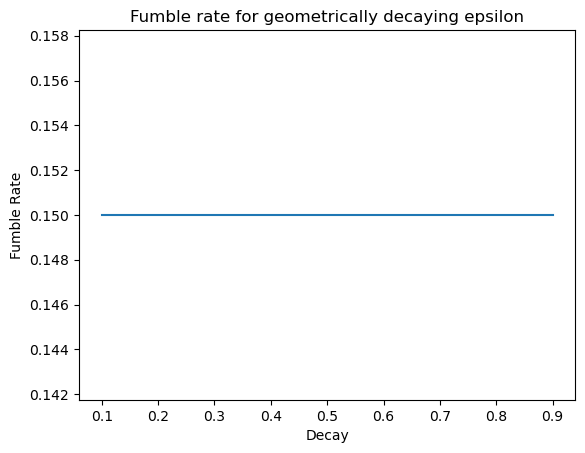

In [193]:
plt.plot(decays, fumble_rate_by_decay)
plt.xlabel('Decay')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for geometrically decaying epsilon')
plt.show()

In [194]:
policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=get_geometric_schedule(decay=0.6))
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:01<00:00, 58189.54it/s]

Q values at start state: {(0, 3): -0.9417072401327855, (2, 2): -0.9441180137195134, (0, 1): -0.9294865592263162, (1, 1): -0.9312020886155247, (2, 3): -0.9660149967131463, (1, 3): -0.9334573727526851, (1, 2): -0.90130253221389, (0, 2): -0.9639966747665677, (2, 1): -0.9243624328012561}
number of fumbles: 3
total number of winning positions: 20
percentage of winning positions fumbled: 15.00 %


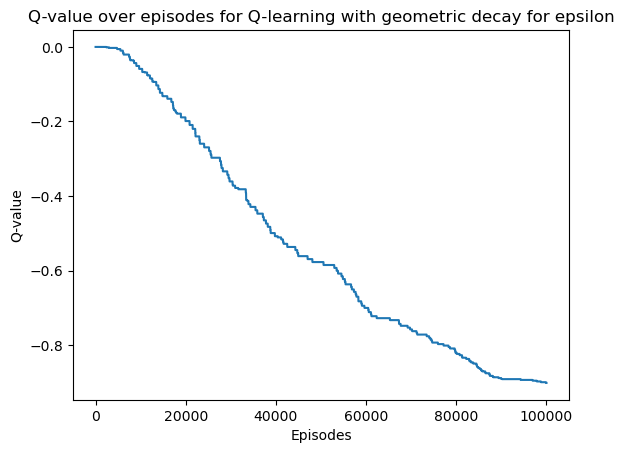

In [195]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with geometric decay for epsilon')
plt.show()

In [196]:
def get_inverse_time_decay_step_size_schedule(initial_alpha=0.1, decay=0.01):
    return [initial_alpha / (1.0 + decay * i) for i in range(max_episodes)]

def get_exponential_step_size_schedule(initial_alpha=0.1, decay=0.99):
    return [initial_alpha * (decay ** i) for i in range(max_episodes)]

def get_step_wise_decay_schedule(initial_alpha=0.1, decay=0.9, num_steps=10):
    return [initial_alpha * (decay ** (i // num_steps)) for i in range(max_episodes)]

In [197]:
for step_size_schedule in [
    ('inverse time decay', get_inverse_time_decay_step_size_schedule()),
    ('exponential decay', get_exponential_step_size_schedule()),
    ('step-wise decay', get_step_wise_decay_schedule())
]:
    print("Using step size schedule:", step_size_schedule[0])
    policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, step_size_schedule=step_size_schedule[1], epsilon_schedule=get_geometric_schedule(decay=0.3))
    evaluate_using_fumbles(policy, Q)

Using step size schedule: inverse time decay


100%|██████████| 100000/100000 [00:01<00:00, 57322.16it/s]


Q values at start state: {(0, 1): -0.007382471642581482, (2, 1): -0.006848639908158383, (1, 2): -0.020455723223527948, (0, 3): -0.008984840882467784, (1, 3): -0.011965417996817615, (1, 1): -0.005065796441075162, (2, 2): -0.004175996585315445, (0, 2): -0.007813893672258139, (2, 3): -0.014685297748996875}
number of fumbles: 0
total number of winning positions: 20
percentage of winning positions fumbled: 0.00 %
Using step size schedule: exponential decay


100%|██████████| 100000/100000 [00:01<00:00, 57399.12it/s]


Q values at start state: {(0, 1): -1.0343663833916229e-07, (0, 3): -2.2508266875105072e-05, (2, 2): -6.239811047078032e-06, (2, 1): -2.882569694378283e-06, (1, 1): -1.762004732964425e-06, (1, 3): -1.7812578010564096e-05, (0, 2): -1.358445677691023e-06, (1, 2): -1.4309940996315752e-08, (2, 3): -1.047886859510751e-14}
number of fumbles: 3
total number of winning positions: 20
percentage of winning positions fumbled: 15.00 %
Using step size schedule: step-wise decay


100%|██████████| 100000/100000 [00:01<00:00, 59637.47it/s]

Q values at start state: {(2, 1): -0.0009007163811164536, (0, 2): -0.0002277002285488267, (2, 2): -0.0009857663198009948, (1, 1): -0.00126217932312205, (0, 3): -0.0002986239855936026, (1, 2): -2.7224868335252635e-06, (1, 3): -2.184745466794866e-06, (0, 1): -3.4790436437528424e-09, (2, 3): -7.406661906470272e-11}
number of fumbles: 3
total number of winning positions: 20
percentage of winning positions fumbled: 15.00 %


In [45]:
policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=get_geometric_schedule(decay=0.6), prob_optimal=0.6)
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:22<00:00, 44021.69it/s]


Q values at start state: {(2, 4): -0.37150445775598373, (0, 1): -0.421799833292326, (2, 2): -0.3874563534554915, (1, 2): -0.39582196153627186, (2, 5): -0.27694810396002767, (0, 2): -0.41608996859096226, (0, 5): -0.32147891131571404, (1, 5): -0.33484097696390913, (1, 1): -0.49996690397764604, (1, 3): -0.40754672418655424, (2, 3): -0.3836296472841955, (2, 1): -0.48625147848092726, (0, 3): -0.4329198657943897, (0, 4): -0.42283864404530663, (1, 4): -0.4453570155804914}
number of fumbles: 38
total number of winning positions: 106
percentage of winning positions fumbled: 35.85 %


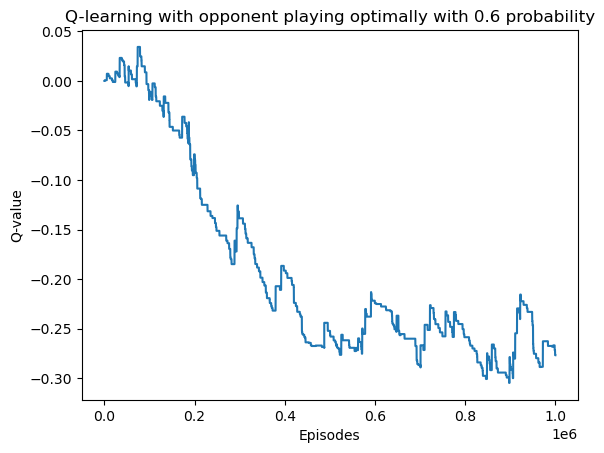

In [46]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-learning with opponent playing optimally with 0.6 probability')
plt.show()

In [200]:
# compare fumbles over different probabilities of optimal play
prob_optimal_values = np.linspace(0.0, 1.0, 11)
fumble_rate_by_prob_optimal = []

for prob_optimal in prob_optimal_values:
    print(f'probability of optimal play: {prob_optimal}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters, prob_optimal=prob_optimal)

    fumble_rate_by_prob_optimal.append(float(total_fumbles)/float(num_winning_pos*num_iters))

probability of optimal play: 0.0
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 45399.53it/s]


Q values at start state: {(0, 2): 0.1736020591987198, (0, 1): 0.23222444275723536, (2, 3): 0.282886279846021, (1, 1): 0.3071863386123099, (2, 1): 0.25756832820174147, (2, 2): 0.3016064315834518, (0, 3): 0.3483589428623164, (1, 2): 0.21549312748764013, (1, 3): 0.17677483409905373}
iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 46259.22it/s]


Q values at start state: {(0, 2): 0.2597075888551139, (1, 2): 0.3266159883775568, (0, 3): 0.310502452509138, (2, 1): 0.27330377651674675, (0, 1): 0.18532307947400284, (1, 3): 0.21733362036646808, (1, 1): 0.3286530412841037, (2, 2): 0.2996777954097167, (2, 3): 0.35435620799794937}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 46107.79it/s]


Q values at start state: {(0, 2): 0.1320619872742357, (2, 1): 0.3449314419563874, (1, 1): 0.3166253434867631, (1, 2): 0.2603629982361234, (2, 3): 0.2362382697179667, (2, 2): 0.3491121517981566, (0, 1): 0.2556466958286891, (1, 3): 0.19266813616026468, (0, 3): 0.339299182819113}
probability of optimal play: 0.1
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 46739.57it/s]


Q values at start state: {(2, 3): 0.21866803210990654, (1, 1): 0.1488793391668693, (2, 1): 0.19097723003202197, (0, 2): -0.02865382078427109, (1, 3): 0.27409290542407, (0, 1): 0.09812227190305954, (2, 2): 0.17200084935941917, (0, 3): 0.16858412118902802, (1, 2): 0.14837222164266173}
iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 45526.81it/s]


Q values at start state: {(2, 3): 0.2814256487853334, (2, 2): 0.20572605066634284, (0, 2): -0.07488262038045526, (0, 3): 0.277842301259946, (1, 1): 0.2022216894637211, (1, 3): 0.1727651713548592, (2, 1): 0.18653859179458476, (1, 2): 0.2554227962316209, (0, 1): 0.11157076574551827}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 46280.70it/s]


Q values at start state: {(2, 3): 0.2432830496457282, (2, 2): 0.1570368277130202, (0, 3): 0.20298958735689313, (0, 2): 0.07229246280742571, (1, 2): 0.2485446198706645, (1, 1): 0.20522266499404535, (0, 1): 0.12152736243354116, (2, 1): 0.18996640572292903, (1, 3): 0.17490703335475896}
probability of optimal play: 0.2
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 47800.18it/s]


Q values at start state: {(2, 2): 0.09791602329664677, (0, 1): 0.015035151502223405, (2, 3): 0.17812503601904697, (1, 2): 0.06912475414803515, (2, 1): 0.10395757278851173, (0, 3): 0.041254886133415464, (1, 3): 0.07973484761658875, (1, 1): 0.10016850545638292, (0, 2): -0.10023334084586726}
iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 47502.71it/s]


Q values at start state: {(2, 3): 0.08287429299126328, (2, 1): 0.058225848723503545, (0, 2): -0.0062084436231569845, (1, 1): 0.07288436135557717, (0, 3): 0.0720599481273203, (2, 2): 0.07512876600768506, (1, 3): 0.17460087068988225, (1, 2): 0.15118638742455007, (0, 1): 0.0574625277689412}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 47974.20it/s]


Q values at start state: {(1, 2): 0.059427840109537174, (2, 3): 0.14826638637850714, (2, 1): 0.0811612367375207, (0, 3): 0.11795787773889313, (1, 3): 0.12823286528245764, (1, 1): 0.1045489680068741, (0, 1): -0.00046881878451748176, (2, 2): 0.08549147105108543, (0, 2): -0.03935756133527664}
probability of optimal play: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 48763.48it/s]


Q values at start state: {(0, 2): -0.028738879193355667, (2, 1): -0.049027761817373276, (1, 1): -0.0608896936217269, (0, 1): -0.08256813904739986, (2, 3): 0.010762299884366475, (2, 2): -0.028303189029298167, (1, 2): 0.05137593960283878, (0, 3): 0.07589721361049627, (1, 3): -0.10316501569529965}
iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 48428.77it/s]


Q values at start state: {(0, 1): -0.08792384908859772, (2, 3): 0.007832841787654716, (0, 2): -0.0913861637493778, (1, 1): -0.10342505065114928, (1, 3): -0.014726961891998482, (2, 1): -0.010610783643664318, (1, 2): -0.011476808366698009, (0, 3): 0.060041653052969046, (2, 2): -0.011244892231303266}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 48726.21it/s]


Q values at start state: {(1, 3): -0.06081921717741614, (2, 1): -0.04584048737058551, (2, 3): -0.003670928310601131, (0, 1): -0.07680985268076788, (0, 3): 0.009167165884683293, (1, 1): -0.01274860406593185, (1, 2): -0.04990248175167351, (0, 2): -0.049919689099876735, (2, 2): -0.04916357445699864}
probability of optimal play: 0.4
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 48487.34it/s]


Q values at start state: {(1, 2): -0.14631686482262107, (2, 1): -0.18280405010485196, (2, 3): 0.07448182797354223, (1, 1): -0.11016750362044375, (1, 3): -0.18542171289300532, (0, 2): -0.21527450390612216, (0, 3): -0.1463022921606503, (0, 1): -0.20869616683617997, (2, 2): -0.17030107525482238}
iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 49764.06it/s]


Q values at start state: {(0, 3): -0.05338594570320138, (2, 3): -0.1639077500362301, (1, 2): -0.06901608061493746, (0, 1): -0.23918971251026874, (1, 3): -0.03010221587880446, (0, 2): -0.27779163542914836, (2, 1): -0.16777902367291417, (2, 2): -0.13087444047137015, (1, 1): -0.14954311151504943}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 49409.95it/s]


Q values at start state: {(0, 3): -0.14026571244234357, (1, 2): -0.1538441855008442, (2, 3): -0.08625099932138083, (1, 3): -0.1277153639102824, (0, 1): -0.18437250026317148, (0, 2): -0.17428333752793632, (2, 2): -0.11614506742659225, (2, 1): -0.20872924603510748, (1, 1): -0.19217774703771776}
probability of optimal play: 0.5
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 50456.66it/s]


Q values at start state: {(0, 3): -0.24041453300215995, (1, 1): -0.2676306405168224, (0, 1): -0.26241395492918296, (2, 1): -0.23983324737402212, (1, 3): -0.19398010947938119, (0, 2): -0.2237455264721147, (2, 2): -0.23189998906703424, (2, 3): -0.22487736714914833, (1, 2): -0.21730642773394304}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 50434.82it/s]


Q values at start state: {(1, 3): -0.25723007712334195, (0, 1): -0.3621434600592156, (2, 3): -0.11032392757251754, (2, 1): -0.2706820724402682, (0, 2): -0.34387638247366753, (1, 2): -0.2892637032944095, (1, 1): -0.2609794532816185, (2, 2): -0.2523121235724608, (0, 3): -0.23078292731897082}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 49980.87it/s]


Q values at start state: {(1, 3): -0.2298618711807932, (1, 2): -0.15747528684285594, (2, 1): -0.33292475346053507, (2, 3): -0.28740019768756964, (1, 1): -0.24593528766606987, (0, 3): -0.24609436778598826, (2, 2): -0.24556922021715097, (0, 1): -0.2893460177572428, (0, 2): -0.23606193782394694}
probability of optimal play: 0.6000000000000001
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51702.56it/s]


Q values at start state: {(2, 1): -0.43585095778496596, (2, 3): -0.3741780203096776, (1, 1): -0.40107341075482544, (0, 3): -0.31175893688404666, (1, 3): -0.37130704661344777, (1, 2): -0.33890513202096556, (2, 2): -0.39295626516305304, (0, 1): -0.460521961876286, (0, 2): -0.3962961800684137}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51552.07it/s]


Q values at start state: {(0, 2): -0.4462702943583538, (0, 1): -0.45452423919042945, (2, 1): -0.39246915543169125, (0, 3): -0.4696114369866425, (2, 2): -0.32617396796974646, (2, 3): -0.34585417943889396, (1, 1): -0.2991515805607001, (1, 2): -0.4225159756813376, (1, 3): -0.3049790400730469}
iteration 3


100%|██████████| 100000/100000 [00:02<00:00, 49713.69it/s]


Q values at start state: {(1, 2): -0.4208488564442837, (0, 3): -0.3393631031969866, (1, 3): -0.3955552454721387, (0, 2): -0.47308243505043673, (0, 1): -0.46589182972474386, (2, 1): -0.47835217286897636, (2, 2): -0.3852636177364992, (2, 3): -0.39597811009336564, (1, 1): -0.32602282054059606}
probability of optimal play: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52209.18it/s]


Q values at start state: {(1, 2): -0.49649261181217075, (1, 1): -0.5136404169799925, (0, 2): -0.4922281463245187, (1, 3): -0.46216129529079636, (2, 1): -0.5937152738723088, (0, 3): -0.5036035655571782, (0, 1): -0.4943448682272985, (2, 3): -0.5433929053951662, (2, 2): -0.5162949060822368}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51962.74it/s]


Q values at start state: {(1, 1): -0.5719546213696176, (2, 2): -0.5114378087236706, (0, 2): -0.622754092291604, (2, 3): -0.4776720254274115, (2, 1): -0.5201328018214073, (1, 3): -0.5127403081724458, (1, 2): -0.47956944932690204, (0, 1): -0.618900893658432, (0, 3): -0.5164802223965956}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 50046.45it/s]


Q values at start state: {(2, 1): -0.5751706281598954, (1, 3): -0.411089205967678, (1, 1): -0.5130004436701434, (0, 3): -0.5323438438651656, (0, 1): -0.5358217409350022, (1, 2): -0.5774400950057241, (2, 2): -0.5583082712062508, (0, 2): -0.5078667215346933, (2, 3): -0.47868602587154196}
probability of optimal play: 0.8
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 54095.70it/s]


Q values at start state: {(2, 1): -0.7256987413038168, (1, 1): -0.6934986785215673, (1, 3): -0.6372650698775848, (1, 2): -0.6336975930951446, (0, 3): -0.7250677257703471, (2, 2): -0.6176436342317586, (0, 1): -0.6961392982824604, (2, 3): -0.6390845185796534, (0, 2): -0.7696220164236574}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 53186.01it/s]


Q values at start state: {(0, 3): -0.6178884913154651, (2, 2): -0.6687871170611841, (1, 2): -0.6264564595369922, (0, 1): -0.6747926620167596, (2, 3): -0.5691586325923911, (0, 2): -0.6773569067051483, (1, 3): -0.5621037618243107, (1, 1): -0.6535346536569744, (2, 1): -0.7380615720119541}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 54633.54it/s]


Q values at start state: {(0, 3): -0.6584445733620007, (0, 2): -0.6635476733703881, (2, 3): -0.6518594140677254, (2, 1): -0.6679979286569346, (1, 2): -0.6859878294241127, (1, 1): -0.616988122342218, (2, 2): -0.639593377029643, (0, 1): -0.6832518652626223, (1, 3): -0.6311496475246896}
probability of optimal play: 0.9
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 54825.68it/s]


Q values at start state: {(0, 2): -0.7904271232536783, (0, 3): -0.8300146088513496, (2, 1): -0.8522139640212855, (1, 3): -0.7309242796670911, (2, 3): -0.7896944283654765, (0, 1): -0.7846767829190874, (2, 2): -0.7645353177836811, (1, 1): -0.7173500417676764, (1, 2): -0.8035318893983668}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 55830.83it/s]


Q values at start state: {(1, 1): -0.8343938319803386, (0, 3): -0.752578465665884, (1, 2): -0.8375358443192501, (2, 2): -0.8326706304038639, (0, 1): -0.8390929874234054, (2, 3): -0.8197835807476658, (0, 2): -0.8131620273033736, (2, 1): -0.8302213755610598, (1, 3): -0.791383819954459}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 55665.79it/s]


Q values at start state: {(2, 3): -0.7342168858041034, (1, 3): -0.8204102538015838, (2, 1): -0.8279798380427784, (2, 2): -0.8426530519794184, (0, 1): -0.8167154924728142, (0, 2): -0.8317511085889382, (0, 3): -0.7265606428785633, (1, 2): -0.8658014089653738, (1, 1): -0.8385715700696422}
probability of optimal play: 1.0
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 57445.25it/s]


Q values at start state: {(1, 3): -0.9268547991133735, (0, 2): -0.9324107963080601, (0, 3): -0.9234866237329411, (2, 3): -0.9430711974210373, (1, 1): -0.9274847134928594, (0, 1): -0.9370930819122097, (1, 2): -0.9059769421902792, (2, 2): -0.9370884029718305, (2, 1): -0.9310766335957086}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 56432.74it/s]


Q values at start state: {(0, 3): -0.9586099398283886, (1, 3): -0.920660642485907, (1, 2): -0.9294585102822609, (2, 2): -0.9427688294145905, (1, 1): -0.9433642313033214, (2, 3): -0.9425609371436455, (0, 2): -0.9444823744933839, (2, 1): -0.946104568058763, (0, 1): -0.9282474289020931}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 57287.25it/s]

Q values at start state: {(2, 3): -0.9595231429607088, (2, 2): -0.9436426809499552, (0, 2): -0.9450333074458325, (1, 2): -0.8903830003887253, (1, 3): -0.929691947323858, (2, 1): -0.9511810356900476, (0, 1): -0.9318021345712227, (1, 1): -0.9257063445352605, (0, 3): -0.9473994349079837}


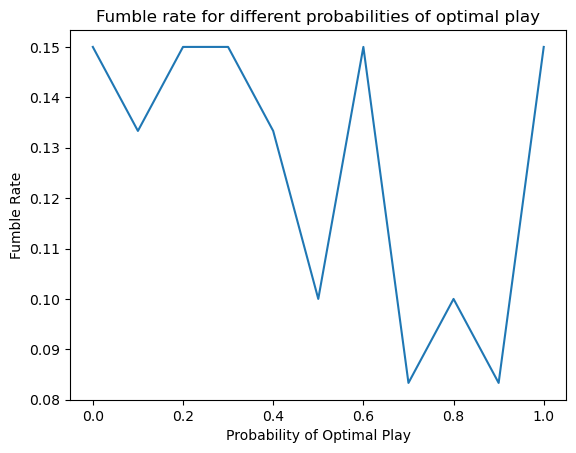

In [201]:
plt.plot(prob_optimal_values, fumble_rate_by_prob_optimal)
plt.xlabel('Probability of Optimal Play')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different probabilities of optimal play')
plt.show()

### Sarsa($\lambda$)

In [202]:
# SARSA lambda
def sarsa_lambda(lamb=0.2, gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_negative_on_loss, epsilon_schedule=None, prob_optimal=1.0, epsilon_schedule_update=None):
    Q = {} # take default to be zero
    E = {} # eligibility traces

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    if epsilon_schedule_update is None and epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))

        while not game.is_game_over():
            R, S1 = sample_step(game, A, prob_optimal=prob_optimal)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}
            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]

            if S not in E:
                E[S] = {}
            if A not in E[S]:
                E[S][A] = 0

            E[S][A] += 1  # Increment eligibility trace for the current state-action pair

            # Update all state-action pairs
            for s in Q:
                for a in Q[s]:
                    if s not in E:
                        E[s] = {}
                    if a not in E[s]:
                        E[s][a] = 0

                    # Update Q-value using eligibility trace
                    Q[s][a] += step_size * delta * E[s][a]

                    # Decay eligibility traces
                    E[s][a] *= lamb * gamma

            A = A1
            S = S1

        # Reset eligibility traces for the next episode
        E = {}

        if epsilon_schedule is not None: policy.update(epsilon=epsilon_schedule[i])
        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

    print("Q values at start state:", Q.get(start_state, {}))

    return policy, Q, Q_history

Lambda: 0.1
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 6110.28it/s]


Q values at start state: {(0, 3): 0.8723420882814702, (1, 2): -0.9168216873977205, (2, 1): -0.9403082175906404, (2, 3): 0.8648553348891994, (2, 2): -0.9402254650236338, (1, 3): 0.8306011139134727, (0, 2): -0.9231152510160633, (1, 1): -0.9130374771284643, (0, 1): -0.9357876358157065}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Lambda: 0.2
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 6143.43it/s]


Q values at start state: {(2, 1): -0.9247483068087546, (0, 2): -0.9427267044886861, (2, 3): 0.922132929775154, (1, 3): 0.8757288051454225, (2, 2): -0.9522862830601411, (0, 1): -0.9395753657498647, (0, 3): 0.9147710368180006, (1, 2): -0.9403312791518356, (1, 1): -0.912704014758668}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Lambda: 0.5
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 6224.36it/s]


Q values at start state: {(1, 1): -0.9375627252944913, (1, 3): 0.9035299554645184, (2, 2): -0.9391682492035414, (0, 3): 0.7407568025493874, (2, 3): 0.9154409700362904, (0, 2): -0.9515432267876965, (0, 1): -0.94372226461029, (1, 2): -0.9426814489288248, (2, 1): -0.9545798598554358}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Lambda: 0.8
iteration 1


100%|██████████| 100000/100000 [00:15<00:00, 6251.87it/s]


Q values at start state: {(1, 2): -0.908629962951789, (1, 1): -0.9342462539149643, (2, 3): 0.9022137970074255, (2, 2): -0.9189233778059034, (2, 1): -0.9418198117735296, (1, 3): 0.8581173354185462, (0, 2): -0.9527856669902919, (0, 3): 0.8862631702952016, (0, 1): -0.9462993183100834}
Average number of fumbles: 0.0
Fumble rate: 0.00%


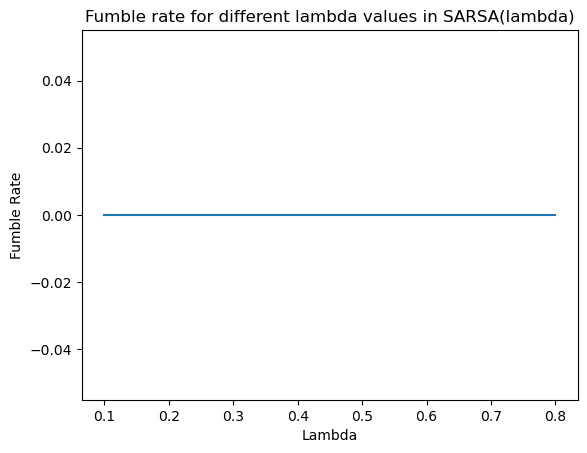

In [203]:
# plot the fumble rate for SARSA lambda for different lambdas
lambdas = [0.1, 0.2, 0.5, 0.8]
fumble_rates = []

best_lambda = 0.0
best_fumble_rate = float('inf')

for lamb in lambdas:
    print(f'Lambda: {lamb}')
    num_iters = 1
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa_lambda, num_iters=num_iters)
    fumble_rates.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rates[-1] * 100))

    if fumble_rates[-1] < best_fumble_rate:
        best_fumble_rate = fumble_rates[-1]
        best_lambda = lamb

plt.plot(lambdas, fumble_rates)
plt.xlabel('Lambda')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different lambda values in SARSA(lambda)')
plt.show()

In [204]:
policy, Q, history = sarsa_lambda(lamb=best_lambda)
evaluate_using_fumbles(policy, Q)

100%|██████████| 100000/100000 [00:16<00:00, 6157.71it/s]

Q values at start state: {(1, 3): 0.8375401579879629, (2, 2): -0.9276311585832109, (0, 1): -0.9449583810096465, (1, 2): -0.9132950572123896, (0, 2): -0.9494454859165473, (0, 3): 0.8559814871763475, (2, 3): 0.9169397338653914, (2, 1): -0.9594692511989655, (1, 1): -0.935169496848969}
number of fumbles: 0
total number of winning positions: 20
percentage of winning positions fumbled: 0.00 %


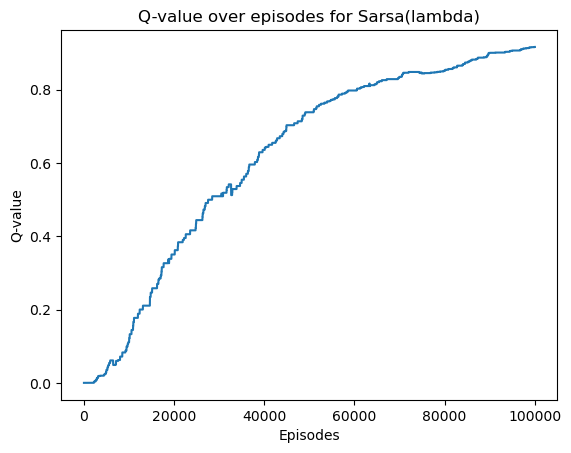

In [205]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa(lambda)')
plt.show()

In [19]:
# Apply the new rewards model with negative rewards for losses
def sample_step_reward_negative_on_loss_self_play(game, A, prob_optimal=1.0, Q_opponent=None):
    if Q_opponent is None:
        return play_optimal_random(game, prob_optimal=prob_optimal)
    else:
        game.make_move(A[0], A[1])

        if game.is_game_over():
            S_next = game.get_state()
            if game.winner() == 0:
                return 1, S_next
            else:
                return -1, S_next

        # Get the current state of the game
        curr_state = game.get_state()
        # Use greedy policy for the opponent
        if curr_state not in Q_opponent or len(Q_opponent[curr_state]) == 0:
            # If no actions available, play randomly
            play_random(game)
        else:
            # Choose the best action for the opponent based on Q values
            opponent_action = max(Q_opponent[curr_state], key=Q_opponent[curr_state].get)
            game.make_move(opponent_action[0], opponent_action[1])

        S_next = game.get_state()
        if game.is_game_over() and game.winner() == 0:
            return 1, S_next
        elif game.is_game_over():
            return -1, S_next
        else:
            return 0, S_next

In [18]:
# Compare two Q-tables over a number of games.
# If Q1 beats Q2 in 55% of the games, it is considered better
def compareQ(Q1, Q2, num_games=1000):
    wins1 = 0
    for i in range(num_games):
        game = SimpleNim([initial_pebbles] * num_heaps)
        if i%2 == 0:
            current_Q, opponent_Q = Q1, Q2
        else:
            current_Q, opponent_Q = Q2, Q1

        while not game.is_game_over():
            state = game.get_state()
            if state not in current_Q or len(current_Q[state]) == 0:
                action = play_random(game)
            else:
                action = max(current_Q[state], key=current_Q[state].get)
                if action[1] == 0:
                    action = play_random(game)
                game.make_move(action[0], action[1])

            if game.is_game_over():
                break

            # Opponent's turn
            state = game.get_state()
            if state not in opponent_Q or len(opponent_Q[state]) == 0:
                play_random(game)
            else:
                action = max(opponent_Q[state], key=opponent_Q[state].get)
                if action[1] == 0:
                    action = play_random(game)
                game.make_move(action[0], action[1])

        if game.winner() == 0:
            wins1 += 1

        return Q1.copy() if wins1 > num_games * 0.55 else Q2

In [25]:
# Q-Learning
def qlearning_self_play(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, epsilon_schedule_update=None, step_size_schedule=None, play_against_optimal_until=100):
    Q = {} # take default to be zero

    Q_opponent = {}  # Q-values for the opponent

    Q_history = []  # To keep track of the Q-value over episodes for plotting

    if epsilon_schedule_update is None and epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            if i > play_against_optimal_until:
                R, S1 = sample_step(game, A, Q_opponent=Q_opponent)
            else:
                R, S1 = sample_step(game, A, Q_opponent=None)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}

            if len(Q[S1]) != 0: Q_max = Q[S1][max(Q[S1])]
            else: Q_max = 0

            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q_max
            delta = target-Q[S][A]
            current_step_size = step_size_schedule[i] if step_size_schedule is not None else step_size
            Q[S][A] = Q[S][A] + current_step_size*delta

            A = A1
            S = game.get_state()

        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        if epsilon_schedule is not None: policy.update(epsilon_schedule[i])

        # Update opponent's Q-values: Best policy until now
        Q_opponent = compareQ(Q, Q_opponent, num_games=10000)

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

    return policy, Q, Q_history

In [20]:
def sample_step_reward_negative_on_loss_self_play_unless_spec(game, A, Q_opponent=None, prob_optimal=1.0):
    if Q_opponent is None:
        return sample_step_reward_negative_on_loss(game, A, prob_optimal=prob_optimal)
    else:
        return sample_step_reward_negative_on_loss_self_play(game, A, Q_opponent=Q_opponent)

#### Self play starting from scratch

In [26]:
policy, Q, history = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, epsilon_schedule=get_geometric_schedule(decay=0.3), play_against_optimal_until=0)
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:39<00:00, 25404.25it/s]


number of fumbles: 59
total number of winning positions: 106
percentage of winning positions fumbled: 55.66 %


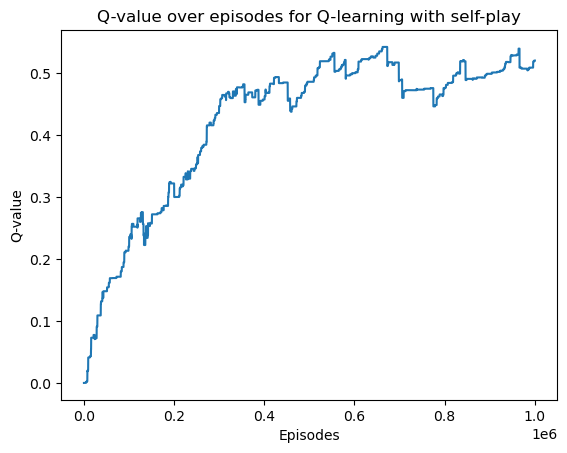

In [27]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with self-play')
plt.show()

### Self play with optimal opponent for a few iterations

- The optimal opponent acts as a guide or teacher for a few iterations just to show the agent a few tricks
- For other games this can be changed to human experience if optimal strategies are not known
- This is done to reduce the iterations wasted on exploring extremely bad policies

- We must not use the optimal guide for too many iterations because that would be cheating, the goal is not to build an agent for Nim(which obviously never outperforms the known optimal strategy) but to look at methods to deal with building RL agents for games

In [28]:
policy, Q, history = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, epsilon_schedule=get_geometric_schedule(decay=0.3), play_against_optimal_until=10000)
evaluate_using_fumbles(policy, Q)

100%|██████████| 1000000/1000000 [00:40<00:00, 24952.79it/s]

number of fumbles: 59
total number of winning positions: 106
percentage of winning positions fumbled: 55.66 %


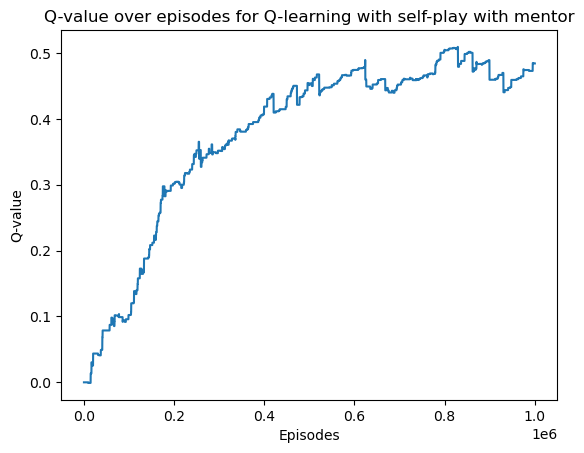

In [29]:
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with self-play with mentor')
plt.show()

#### Note:
- Self play has higher Q-values but maintains a high fumble rate

In [21]:
# Self play with SARSA(lambda)
def sarsa_lambda_self_play(gamma=1, policy=EpsilonGreedyPolicy(), step_size=0.02, exploring_starts=True, sample_step=sample_step_reward_zero_on_loss, epsilon_schedule=None, epsilon_schedule_update=None, step_size_schedule=None, play_against_optimal_until=100, lamb=0.2):
    Q = {} # take default to be zero

    Q_opponent = {}  # Q-values for the opponent

    Q_history = []  # To keep track of the Q-value over episodes for plotting
    E = {}  # Eligibility traces

    if epsilon_schedule_update is None and epsilon_schedule is None: policy.update(0.05)

    for i in tqdm(range(max_episodes)):
        if exploring_starts:
            # Start with a random state and action
            S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            while all(pebble == 0 for pebble in S):
                S = tuple(np.random.randint(0, initial_pebbles + 1, num_heaps).tolist())
            heap_index = np.random.randint(0, num_heaps)
            while S[heap_index] == 0:
                heap_index = np.random.randint(0, num_heaps)
            A = (heap_index, np.random.randint(1, S[heap_index] + 1))
        else:
            S = start_state
            A = policy.policy(S, Q)

        game = SimpleNim(list(S))  # Reset the game

        while not game.is_game_over():
            if i > play_against_optimal_until:
                R, S1 = sample_step(game, A, Q_opponent=Q_opponent)
            else:
                R, S1 = sample_step(game, A, Q_opponent=None)
            if game.is_game_over():
                A1 = (0,0)
            else:
                A1 = policy.policy(S1, Q)

            if S1 not in Q:
                Q[S1] = {}

            if A1 not in Q[S1]:
                Q[S1][A1] = 0
            if S not in Q:
                Q[S] = {}
            if A not in Q[S]:
                Q[S][A] = 0
            target = R + gamma*Q[S1][A1]
            delta = target-Q[S][A]
            if S not in E:
                E[S] = {}
            if A not in E[S]:
                E[S][A] = 0
            E[S][A] += 1  # Increment eligibility trace for the current state-action pair
            # Update all state-action pairs
            for s in Q:
                for a in Q[s]:
                    if s not in E:
                        E[s] = {}
                    if a not in E[s]:
                        E[s][a] = 0

                    # Update Q-value using eligibility trace
                    Q[s][a] += step_size * delta * E[s][a]

                    # Decay eligibility traces
                    E[s][a] *= lamb * gamma

            A = A1
            S = game.get_state()

        if epsilon_schedule_update is not None: epsilon_schedule_update(policy, i)
        if epsilon_schedule is not None: policy.update(epsilon_schedule[i])

        # Update opponent's Q-values: Best policy until now
        Q_opponent = compareQ(Q, Q_opponent, num_games=10000)

        # Track the Q-value for plotting
        if Q:
            toAdd = max(Q[start_state].values()) if start_state in Q and Q[start_state] else 0
            Q_history.append(toAdd)

    return policy, Q, Q_history

100%|██████████| 1000000/1000000 [14:50<00:00, 1122.44it/s]


number of fumbles: 1
total number of winning positions: 106
percentage of winning positions fumbled: 0.94 %


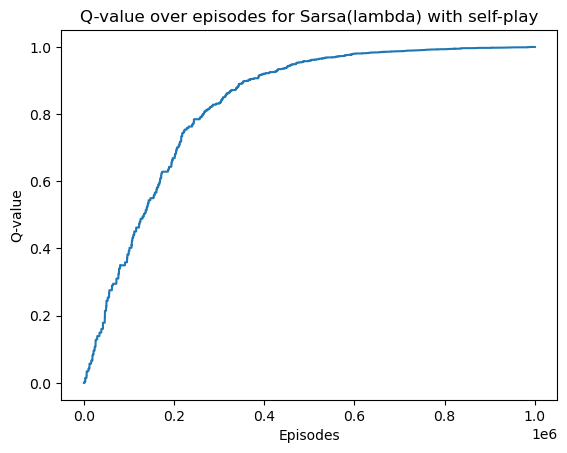

In [24]:
policy, Q, history = sarsa_lambda_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, epsilon_schedule=get_geometric_schedule(decay=0.3), play_against_optimal_until=0)
evaluate_using_fumbles(policy, Q)
plt.plot(history)
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa(lambda) with self-play')
plt.show()

## Discounting:
- It seems that optimal play causes a lot of jaggedness in the Q-values
- This seems to be because of how harshly sample paths are punished in case of a loss
- So let's try discounting and see if that helps

In [214]:
# Evaluate Sarsa with discounted rewards with respect to discounting factor
discounting_factors = np.linspace(0.1, 0.9, 9)
fumble_rate_by_discounting = []
history_by_discounting = []
for discounting_factor in discounting_factors:
    print(f'Discounting factor: {discounting_factor}')
    num_iters = 1
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa, num_iters=num_iters, sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6)

    fumble_rate_by_discounting.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rate_by_discounting[-1] * 100))
    # Train the model with the current discounting factor
    print("Training with discounting factor to get Q-value plot:", discounting_factor)
    policy, Q, history = sarsa(sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6)
    history_by_discounting.append(history)

Discounting factor: 0.1
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51942.92it/s]


Q values at start state: {(0, 1): 0.24217602213295575, (2, 3): 0.9093499188498094, (0, 2): 0.1859328434076973, (2, 1): 0.1817400091687458, (2, 2): 0.1031901395861245, (1, 2): 0.14095647612352352, (1, 3): 0.8730783222042171, (1, 1): 0.19588199390085967, (0, 3): 0.8743483988883595}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.1


100%|██████████| 100000/100000 [00:01<00:00, 52140.83it/s]


Q values at start state: {(2, 2): 0.1396834801762755, (0, 3): 0.8779259145182887, (1, 3): 0.8711221795901517, (0, 1): 0.2129596797163702, (2, 1): 0.2145671087897886, (0, 2): 0.1940993460827199, (1, 2): 0.18153001334509938, (1, 1): 0.23612584084819013, (2, 3): 0.8971130755625518}
Discounting factor: 0.2
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51609.36it/s]


Q values at start state: {(1, 1): 0.27785367248105736, (2, 3): 0.8912741026841232, (0, 1): 0.21806356215627415, (2, 1): 0.22593156540551465, (2, 2): 0.19482492069449908, (0, 2): 0.19904044094070186, (0, 3): 0.9095071313191654, (1, 3): 0.8954998735210468, (1, 2): 0.19924005998813557}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.2


100%|██████████| 100000/100000 [00:01<00:00, 52191.58it/s]


Q values at start state: {(0, 2): 0.22774964247959237, (1, 3): 0.8472936827695423, (1, 2): 0.16102336491304056, (0, 3): 0.8575304385613599, (2, 1): 0.250950405895126, (2, 2): 0.23807198386942977, (2, 3): 0.8607495077413858, (1, 1): 0.23831632601554398, (0, 1): 0.25708160602158836}
Discounting factor: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52220.06it/s]


Q values at start state: {(1, 1): 0.2054594937950113, (0, 3): 0.8454631439154251, (0, 1): 0.18730005079163609, (2, 2): 0.225740875241379, (2, 3): 0.8954740574017651, (2, 1): 0.3111741843217213, (0, 2): 0.15677850777497324, (1, 3): 0.8859767532351386, (1, 2): 0.11919622913140254}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.30000000000000004


100%|██████████| 100000/100000 [00:01<00:00, 52062.57it/s]


Q values at start state: {(2, 1): 0.20542465800109078, (1, 1): 0.2678896750944127, (2, 3): 0.8858179045339111, (1, 2): 0.10276506709318618, (1, 3): 0.85890941350838, (0, 1): 0.2843010430683224, (2, 2): 0.11323404363283872, (0, 3): 0.9286948709100027, (0, 2): 0.16416461673966604}
Discounting factor: 0.4
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52189.61it/s]


Q values at start state: {(0, 3): 0.8851455796199583, (2, 2): 0.3329483868288522, (2, 3): 0.8180498124842484, (0, 2): 0.21899753449614492, (1, 2): 0.19098020063057702, (2, 1): 0.19332860400120438, (1, 1): 0.26342510612358094, (0, 1): 0.21491361292328573, (1, 3): 0.8705850066635469}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.4


100%|██████████| 100000/100000 [00:01<00:00, 52260.78it/s]


Q values at start state: {(1, 3): 0.8989988705120447, (1, 1): 0.24318782296338218, (2, 1): 0.20950625515744176, (0, 1): 0.2580512951534313, (2, 3): 0.9051051203965464, (0, 2): 0.3267448725379504, (1, 2): 0.20118026521040078, (2, 2): 0.1871056883664464, (0, 3): 0.8831664699685949}
Discounting factor: 0.5
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52241.86it/s]


Q values at start state: {(2, 2): 0.22942356817950685, (1, 1): 0.21107774224580422, (0, 1): 0.2784227528161302, (1, 3): 0.8580956248160306, (2, 1): 0.2755694407093852, (0, 3): 0.9012833043815626, (0, 2): 0.23287332277089653, (2, 3): 0.8291992394641543, (1, 2): 0.12139849971666407}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.5


100%|██████████| 100000/100000 [00:01<00:00, 51176.89it/s]


Q values at start state: {(1, 3): 0.8646485647217599, (0, 1): 0.26451708242135386, (2, 1): 0.2149065770943995, (0, 2): 0.22558583536075308, (2, 3): 0.8751067113497315, (1, 2): 0.14605579733160753, (2, 2): 0.23282974499204637, (1, 1): 0.25285027674486044, (0, 3): 0.8854218281019575}
Discounting factor: 0.6
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52154.42it/s]


Q values at start state: {(2, 2): 0.13597516447725264, (2, 1): 0.20634697803815275, (1, 3): 0.8295456309282613, (0, 1): 0.29048994219629837, (0, 2): 0.14894884535347044, (1, 2): 0.1290076616742505, (1, 1): 0.20793535385997197, (0, 3): 0.8534797288951972, (2, 3): 0.8776383545226716}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.6


100%|██████████| 100000/100000 [00:01<00:00, 52309.21it/s]


Q values at start state: {(2, 1): 0.2768979415363215, (0, 3): 0.8858271871042089, (2, 2): 0.15131756912337252, (1, 1): 0.23043199441094986, (0, 2): 0.2021828529125345, (2, 3): 0.8549231093623193, (0, 1): 0.28363336722478694, (1, 2): 0.1658469551777313, (1, 3): 0.8830705728131852}
Discounting factor: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52250.56it/s]


Q values at start state: {(2, 3): 0.8684375214311654, (0, 3): 0.8902998419748556, (0, 2): 0.13176431818640527, (1, 2): 0.148496033839829, (1, 1): 0.14587615512122123, (0, 1): 0.18696598264130426, (2, 1): 0.20723813364428895, (2, 2): 0.17616706404937296, (1, 3): 0.8583191460315263}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.7000000000000001


100%|██████████| 100000/100000 [00:01<00:00, 52347.97it/s]


Q values at start state: {(1, 3): 0.9201229110143563, (0, 3): 0.9204666299892776, (1, 2): 0.24208415115129872, (0, 2): 0.23207886316514215, (2, 3): 0.8849692227964151, (0, 1): 0.277093333245849, (2, 1): 0.3002609373855026, (2, 2): 0.2020780341790933, (1, 1): 0.24252604472383194}
Discounting factor: 0.8
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52232.25it/s]


Q values at start state: {(0, 2): 0.12564359129935518, (2, 2): 0.19434658870481053, (1, 3): 0.8983015335947862, (0, 3): 0.8689515740243354, (1, 2): 0.20821482726543186, (1, 1): 0.23963383101872546, (2, 1): 0.26466866779847653, (0, 1): 0.2328478270729155, (2, 3): 0.8893872779806318}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.8


100%|██████████| 100000/100000 [00:01<00:00, 52116.58it/s]


Q values at start state: {(1, 3): 0.8903094828134512, (2, 2): 0.1925213462729523, (0, 3): 0.8197659742185861, (2, 3): 0.906836747919361, (0, 1): 0.13477134123341217, (1, 2): 0.0928679671692015, (1, 1): 0.30145354093929594, (2, 1): 0.2367262225904458, (0, 2): 0.16384979554843165}
Discounting factor: 0.9
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52149.58it/s]


Q values at start state: {(2, 1): 0.22655221563435113, (0, 1): 0.18674397586932473, (0, 2): 0.15069218743427004, (2, 3): 0.8439616761988324, (1, 3): 0.8632068723282184, (0, 3): 0.9084071932956115, (1, 2): 0.28745957689790136, (2, 2): 0.16973884667218303, (1, 1): 0.24484090461987926}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.9


100%|██████████| 100000/100000 [00:01<00:00, 52380.89it/s]

Q values at start state: {(1, 2): 0.20916314131811906, (1, 1): 0.21183878934955036, (0, 2): 0.16336404517221, (2, 3): 0.8842613078438952, (2, 2): 0.12962511613001682, (0, 1): 0.2426894464069371, (0, 3): 0.8565692972048906, (1, 3): 0.9152205448816882, (2, 1): 0.20842135623506833}


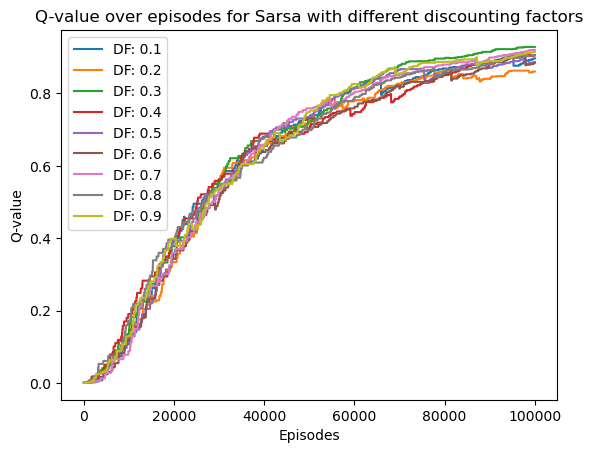

In [215]:
for i, discounting_factor in enumerate(discounting_factors):
    plt.plot(history_by_discounting[i], label=f'DF: {discounting_factor:.1f}')
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa with different discounting factors')
plt.legend()
plt.show()

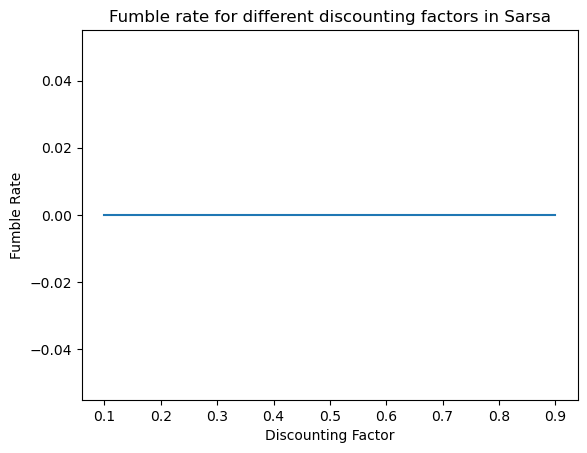

In [216]:
plt.plot(fumble_rate_by_discounting)
plt.xlabel('Discounting Factor')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different discounting factors in Sarsa')
plt.xticks(range(len(discounting_factors)), [f'{df:.1f}' for df in discounting_factors])
plt.show()

#### Observation:
- Significant improvement in convergence properties as well as fumble rate results

So let's try it for the other methods too

In [217]:
# Evaluate Sarsa lambda with respect to discounting factor
fumble_rate_by_discounting_lambda = []
history_by_discounting_lambda = []
for discounting_factor in discounting_factors:
    print(f'Discounting factor: {discounting_factor}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(sarsa_lambda, num_iters=num_iters, sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6)

    fumble_rate_by_discounting_lambda.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rate_by_discounting_lambda[-1] * 100))
    # Train the model with the current discounting factor
    print("Training with discounting factor to get Q-value plot:", discounting_factor)
    policy, Q, history = sarsa_lambda(sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6)
    history_by_discounting_lambda.append(history)

Discounting factor: 0.1
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 5919.41it/s]


Q values at start state: {(2, 1): 0.24519037522950796, (0, 3): 0.8338284681754128, (0, 2): 0.19621852375462037, (2, 3): 0.8935940929655323, (1, 3): 0.8564118624538443, (0, 1): 0.276143454157033, (2, 2): 0.17742025863819244, (1, 2): 0.12872295138129594, (1, 1): 0.18294876307627964}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5854.11it/s]


Q values at start state: {(1, 2): 0.17863027555823432, (0, 3): 0.8850557466947658, (1, 3): 0.8877155595143421, (2, 1): 0.2653323122941799, (0, 2): 0.1579335824891472, (2, 3): 0.8806226899082222, (2, 2): 0.2640105280655357, (0, 1): 0.19026467556787718, (1, 1): 0.2540153658544317}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5877.97it/s]


Q values at start state: {(0, 1): 0.22317951834281413, (0, 3): 0.8955450606829661, (2, 1): 0.19722339669391806, (2, 2): 0.2401258206123377, (0, 2): 0.18586723645186465, (1, 1): 0.18065397365294705, (2, 3): 0.9100559613764946, (1, 2): 0.22213864020308507, (1, 3): 0.8601814054169591}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.1


100%|██████████| 100000/100000 [00:16<00:00, 5886.16it/s]


Q values at start state: {(2, 1): 0.22800212389269703, (0, 1): 0.36477145441702913, (1, 1): 0.1628011297768975, (2, 2): 0.14285807186653532, (2, 3): 0.8732328969826778, (1, 3): 0.9237087711962814, (0, 3): 0.8680027461817715, (0, 2): 0.2353272076945629, (1, 2): 0.2870073728589948}
Discounting factor: 0.2
iteration 1


100%|██████████| 100000/100000 [00:17<00:00, 5858.92it/s]


Q values at start state: {(1, 3): 0.8916348910183984, (0, 3): 0.8667375973425312, (2, 3): 0.8712115010949467, (2, 2): 0.2262918681829342, (1, 2): 0.143426347481972, (0, 1): 0.21356109374322385, (0, 2): 0.2063830252366182, (2, 1): 0.17085796809594586, (1, 1): 0.2507413994437983}
iteration 2


100%|██████████| 100000/100000 [00:16<00:00, 6015.62it/s]


Q values at start state: {(2, 2): 0.21227650458849526, (1, 2): 0.18057999171360348, (1, 3): 0.8768619543300733, (0, 1): 0.24783992781990136, (0, 3): 0.842454670525153, (1, 1): 0.2483187556752286, (2, 1): 0.2302940352256768, (0, 2): 0.15427184063803387, (2, 3): 0.8776525712358141}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5876.60it/s]


Q values at start state: {(2, 2): 0.1763358835480583, (0, 2): 0.15588193652070909, (2, 1): 0.18365662361235466, (0, 3): 0.868595024058569, (1, 1): 0.21636013316414587, (1, 3): 0.8773240758926695, (0, 1): 0.23528512444400773, (2, 3): 0.8732880026107541, (1, 2): 0.18285532688517026}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.2


100%|██████████| 100000/100000 [00:16<00:00, 5939.76it/s]


Q values at start state: {(1, 3): 0.9199780761878273, (0, 2): 0.16803804767179448, (0, 3): 0.8819433880831274, (1, 2): 0.22544223808270852, (2, 2): 0.147302965052878, (0, 1): 0.3827405874581508, (2, 1): 0.20917068952421014, (1, 1): 0.1608353746983791, (2, 3): 0.8748174087902838}
Discounting factor: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:17<00:00, 5814.71it/s]


Q values at start state: {(1, 3): 0.8790214788738475, (2, 1): 0.20216227460309655, (1, 1): 0.2706290257658632, (2, 3): 0.7917606280368837, (0, 2): 0.19736119471909735, (0, 1): 0.24462749370412154, (0, 3): 0.8731493655461021, (1, 2): 0.1370662070866576, (2, 2): 0.1263066986445279}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5856.09it/s]


Q values at start state: {(2, 2): 0.2009137178454826, (2, 1): 0.2657691469710949, (0, 2): 0.24805034840215448, (1, 1): 0.23676816546693819, (0, 1): 0.21135461955709667, (1, 2): 0.26496436243713073, (0, 3): 0.89918470218745, (2, 3): 0.9057691849675066, (1, 3): 0.8662934129333254}
iteration 3


100%|██████████| 100000/100000 [00:16<00:00, 5901.37it/s]


Q values at start state: {(2, 3): 0.8489059834911943, (1, 2): 0.1964148281614332, (1, 3): 0.8725688424339256, (2, 2): 0.15457911541920172, (0, 1): 0.21064369103871322, (1, 1): 0.13738310293521563, (0, 2): 0.1671666595762319, (0, 3): 0.8877865826510095, (2, 1): 0.3015853388283912}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.30000000000000004


100%|██████████| 100000/100000 [00:17<00:00, 5847.07it/s]


Q values at start state: {(0, 1): 0.35508662670174845, (2, 1): 0.18691537755560914, (0, 2): 0.16910445408082256, (0, 3): 0.896294218055718, (1, 3): 0.9033236875128704, (2, 2): 0.15392083496816847, (1, 2): 0.20760436194112447, (2, 3): 0.9209961804529817, (1, 1): 0.22242423141451623}
Discounting factor: 0.4
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 5912.35it/s]


Q values at start state: {(2, 2): 0.18449541820679213, (0, 3): 0.8773736433712721, (2, 1): 0.15905016788996162, (2, 3): 0.8565036052183956, (1, 1): 0.2535243202936202, (0, 2): 0.18376614293574695, (1, 2): 0.19383268516962038, (1, 3): 0.9059157098610231, (0, 1): 0.2830161512465675}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5862.50it/s]


Q values at start state: {(1, 1): 0.18446536109280595, (0, 1): 0.28107649805592544, (0, 2): 0.13534621866515895, (1, 3): 0.9063453544682073, (2, 1): 0.2726898311055997, (2, 3): 0.9087263777166177, (1, 2): 0.2204177161341974, (2, 2): 0.1786896589403238, (0, 3): 0.923865507096707}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5858.80it/s]


Q values at start state: {(1, 2): 0.1218972105676472, (1, 1): 0.1700301716404494, (0, 1): 0.2928239237880723, (2, 1): 0.21093457549451472, (0, 2): 0.20771980313887897, (2, 3): 0.8277842175734221, (0, 3): 0.9181218156243798, (1, 3): 0.8561153633804605, (2, 2): 0.09786456903664166}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.4


100%|██████████| 100000/100000 [00:17<00:00, 5828.88it/s]


Q values at start state: {(2, 3): 0.9027571055123396, (1, 3): 0.8533857941301183, (1, 1): 0.22232388901811234, (2, 1): 0.2017113187455737, (1, 2): 0.17481258961467128, (0, 3): 0.886703081293435, (0, 1): 0.19206479711136923, (2, 2): 0.11655983260771673, (0, 2): 0.19589342362932224}
Discounting factor: 0.5
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 5956.86it/s]


Q values at start state: {(0, 2): 0.13824258343621226, (2, 1): 0.2033318222702328, (1, 3): 0.8659223002804665, (1, 2): 0.17988066281044693, (2, 2): 0.20706855617080175, (1, 1): 0.21522587890427453, (0, 3): 0.8669058051700831, (2, 3): 0.8723122149996851, (0, 1): 0.2262018382996763}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5821.02it/s]


Q values at start state: {(2, 1): 0.14266026022660688, (2, 2): 0.16737056960694968, (2, 3): 0.8916652584289911, (0, 1): 0.23197586166501658, (0, 2): 0.1638353626214964, (0, 3): 0.9113666272895176, (1, 3): 0.8898450392803394, (1, 2): 0.135900439504457, (1, 1): 0.33322495088426896}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5865.56it/s]


Q values at start state: {(0, 2): 0.2434573913587086, (1, 1): 0.2814912035361036, (2, 2): 0.20151786537056954, (2, 1): 0.33883754038878966, (0, 3): 0.8706241562319362, (1, 2): 0.17877815993975324, (2, 3): 0.8489182046176946, (0, 1): 0.2305399875709639, (1, 3): 0.8786351662601304}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.5


100%|██████████| 100000/100000 [00:17<00:00, 5844.46it/s]


Q values at start state: {(1, 2): 0.2315823541682119, (2, 3): 0.8620793498136974, (2, 1): 0.2757551761101334, (2, 2): 0.14955977454582084, (0, 1): 0.2384611182437602, (0, 3): 0.9151563839362905, (1, 3): 0.8908867959192759, (0, 2): 0.22093815371554426, (1, 1): 0.25603501977457427}
Discounting factor: 0.6
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 5918.92it/s]


Q values at start state: {(2, 3): 0.8874726384372916, (0, 3): 0.8931416153773621, (0, 1): 0.21754257502435562, (1, 2): 0.11173120041503769, (1, 1): 0.19048798195904362, (0, 2): 0.1443189252527138, (2, 1): 0.21283361818107113, (1, 3): 0.8076507306068165, (2, 2): 0.21288702083941474}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5852.31it/s]


Q values at start state: {(2, 1): 0.26363508608148223, (0, 1): 0.24429004619316858, (2, 3): 0.9160197003981496, (1, 3): 0.8477571514450088, (1, 2): 0.24825287048571634, (1, 1): 0.26468181305033395, (0, 2): 0.1828656057054408, (0, 3): 0.8508926036608103, (2, 2): 0.10849777702901568}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5671.25it/s]


Q values at start state: {(1, 2): 0.15655434557058887, (2, 1): 0.1858928868986554, (0, 2): 0.20149272753905917, (2, 3): 0.8842945899905328, (0, 3): 0.8804002020488763, (2, 2): 0.20557100614449386, (1, 1): 0.22926505906161868, (1, 3): 0.8902367055039312, (0, 1): 0.24862380100471485}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.6


100%|██████████| 100000/100000 [00:17<00:00, 5666.41it/s]


Q values at start state: {(0, 2): 0.16363186524303985, (2, 3): 0.9048861339159507, (2, 1): 0.19916428163543992, (0, 3): 0.9414852775859242, (1, 3): 0.9096597461348933, (1, 2): 0.19918060976468577, (0, 1): 0.249294361329806, (1, 1): 0.215325987091204, (2, 2): 0.2224049003997481}
Discounting factor: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:17<00:00, 5798.58it/s]


Q values at start state: {(1, 3): 0.8924426699157707, (2, 1): 0.23530862752937884, (1, 2): 0.17320869728178256, (1, 1): 0.2727902485912909, (2, 2): 0.24307270861439223, (0, 2): 0.20116211147432883, (0, 1): 0.2304352581993646, (0, 3): 0.9138501612933689, (2, 3): 0.8608420853380173}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5736.47it/s]


Q values at start state: {(0, 3): 0.9038288599999335, (1, 1): 0.2538182297056535, (1, 3): 0.8065655890964545, (0, 2): 0.2720563642081723, (2, 3): 0.9033915321747128, (0, 1): 0.21993888509191348, (1, 2): 0.13942491742511137, (2, 1): 0.3250629517657852, (2, 2): 0.1658415207716979}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5817.10it/s]


Q values at start state: {(0, 2): 0.16486448036550358, (2, 3): 0.913427487813185, (2, 1): 0.21632059679985804, (1, 1): 0.22172955642047973, (1, 3): 0.9175838147728171, (0, 3): 0.9199832536957055, (1, 2): 0.23083499440777153, (0, 1): 0.19887945397612333, (2, 2): 0.17364718772982563}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.7000000000000001


100%|██████████| 100000/100000 [00:17<00:00, 5636.08it/s]


Q values at start state: {(2, 1): 0.25725154095515607, (2, 2): 0.15932762743539053, (1, 1): 0.274727045913753, (0, 1): 0.25357003532351513, (0, 2): 0.17164443464753912, (1, 2): 0.17127798276129774, (0, 3): 0.8681826959855535, (1, 3): 0.8790305808127491, (2, 3): 0.8759063921869882}
Discounting factor: 0.8
iteration 1


100%|██████████| 100000/100000 [00:17<00:00, 5683.27it/s]


Q values at start state: {(1, 2): 0.18229049843360348, (0, 2): 0.20763442173591679, (1, 3): 0.9155755206032956, (0, 3): 0.8661065094908659, (2, 1): 0.23593432610161286, (2, 3): 0.8750480319048536, (2, 2): 0.13663296606595476, (0, 1): 0.2949347049161515, (1, 1): 0.24650808066274252}
iteration 2


100%|██████████| 100000/100000 [00:17<00:00, 5611.26it/s]


Q values at start state: {(2, 3): 0.8932701235559827, (0, 2): 0.18616400787473428, (0, 3): 0.903041218693898, (1, 3): 0.8963329020442519, (2, 2): 0.16349257277335383, (0, 1): 0.2909789651886062, (1, 2): 0.16532124959130198, (1, 1): 0.31884475823587033, (2, 1): 0.2722950490015758}
iteration 3


100%|██████████| 100000/100000 [00:17<00:00, 5830.50it/s]


Q values at start state: {(0, 3): 0.9085305200970627, (1, 3): 0.8842157054018671, (0, 2): 0.21549658721473436, (2, 1): 0.2674553288238017, (0, 1): 0.22469366573237703, (1, 1): 0.18458965586750636, (2, 2): 0.11585576296440661, (2, 3): 0.9106747112501787, (1, 2): 0.20463303483938697}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.8


100%|██████████| 100000/100000 [00:17<00:00, 5582.79it/s]


Q values at start state: {(2, 1): 0.17611810671369157, (0, 2): 0.1680096939540193, (2, 2): 0.13213233893778378, (1, 3): 0.9259137532967914, (1, 1): 0.19547775179938479, (1, 2): 0.22463613385080164, (0, 3): 0.9264930037863544, (2, 3): 0.8979143341773781, (0, 1): 0.2723888508891929}
Discounting factor: 0.9
iteration 1


100%|██████████| 100000/100000 [00:16<00:00, 5899.98it/s]


Q values at start state: {(0, 2): 0.21864355802126992, (1, 2): 0.2133398093078006, (0, 3): 0.8935435806393692, (2, 3): 0.860156716288087, (0, 1): 0.2507764080317478, (2, 1): 0.2041121991077056, (2, 2): 0.20652127459193786, (1, 1): 0.2484746771077888, (1, 3): 0.8070370534329989}
iteration 2


100%|██████████| 100000/100000 [00:16<00:00, 5905.15it/s]


Q values at start state: {(0, 1): 0.22129480365919543, (1, 2): 0.14115701811147707, (1, 3): 0.8485904838642997, (1, 1): 0.24510333513725346, (2, 1): 0.31787944904941495, (2, 2): 0.196481845433679, (0, 2): 0.16891629557050752, (0, 3): 0.908072825676042, (2, 3): 0.9197933920143937}
iteration 3


100%|██████████| 100000/100000 [00:16<00:00, 5886.27it/s]


Q values at start state: {(0, 1): 0.1984117950630966, (1, 1): 0.19239424673933464, (1, 2): 0.13508952871916297, (1, 3): 0.8745924507405144, (2, 3): 0.8507014816617362, (0, 2): 0.1786812226291622, (2, 2): 0.10861617118539574, (2, 1): 0.20172171295328692, (0, 3): 0.8529697346738863}
Average number of fumbles: 0.0
Fumble rate: 0.00%
Training with discounting factor to get Q-value plot: 0.9


100%|██████████| 100000/100000 [00:16<00:00, 5899.64it/s]

Q values at start state: {(0, 1): 0.2334544694074467, (0, 3): 0.8504671068441395, (2, 1): 0.21470009540098814, (0, 2): 0.24825142914650986, (1, 1): 0.1886062839098994, (1, 3): 0.9013294613154395, (1, 2): 0.1646096282184632, (2, 2): 0.2323992304807743, (2, 3): 0.8428628755950492}


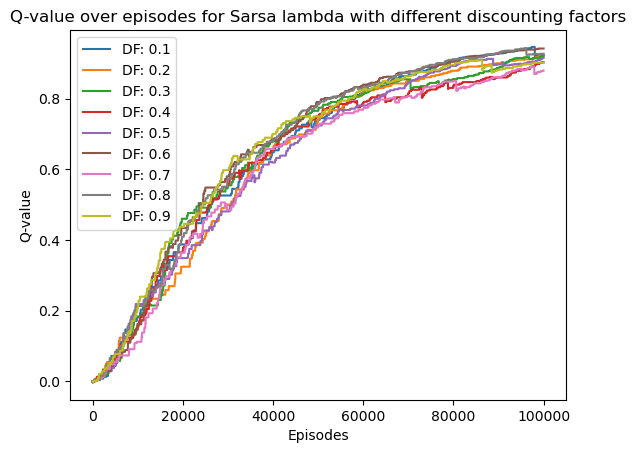

In [218]:
for i, discounting_factor in enumerate(discounting_factors):
    plt.plot(history_by_discounting_lambda[i], label=f'DF: {discounting_factor:.1f}')
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Sarsa lambda with different discounting factors')
plt.legend()
plt.show()

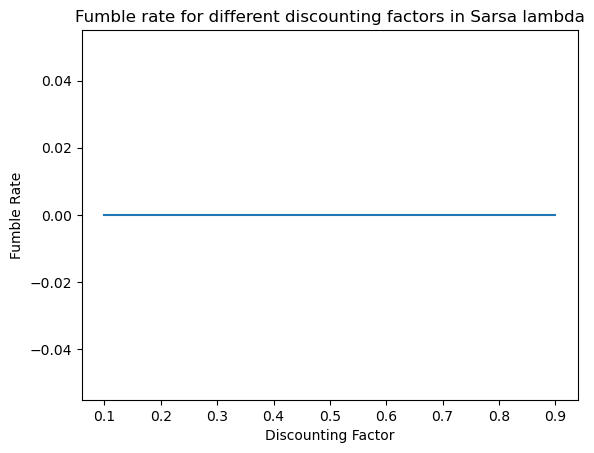

In [219]:
plt.plot(fumble_rate_by_discounting_lambda)
plt.xlabel('Discounting Factor')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different discounting factors in Sarsa lambda')
plt.xticks(range(len(discounting_factors)), [f'{df:.1f}' for df in discounting_factors])
plt.show()

In [220]:
# Evaluate Q-learning with respect to discounting factor for optimal play with probability 0.6
fumble_rate_by_discounting_qlearning = []
history_by_discounting_qlearning = []
for discounting_factor in discounting_factors:
    print(f'Discounting factor: {discounting_factor}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters, sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6, epsilon_schedule=get_geometric_schedule(decay=0.3))

    fumble_rate_by_discounting_qlearning.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rate_by_discounting_qlearning[-1] * 100))
    # Train the model with the current discounting factor
    print("Training with discounting factor to get Q-value plot:", discounting_factor)
    policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6)
    history_by_discounting_qlearning.append(history)

Discounting factor: 0.1
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51800.46it/s]


Q values at start state: {(2, 3): -0.33944357673883585, (1, 2): -0.3600983093164137, (2, 1): -0.38559493523443295, (1, 3): -0.35769034921024756, (0, 3): -0.3215290819853541, (1, 1): -0.3271630299363904, (0, 1): -0.44274564409832373, (0, 2): -0.445978296937722, (2, 2): -0.3558874887730722}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52073.30it/s]


Q values at start state: {(0, 2): -0.42436118067836576, (1, 3): -0.42023058250216794, (2, 3): -0.3540772623795889, (1, 1): -0.3385846720732891, (0, 3): -0.29913908246926935, (1, 2): -0.35403041100607824, (0, 1): -0.43850794683099004, (2, 2): -0.38254496141718564, (2, 1): -0.47739618107252774}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52113.14it/s]


Q values at start state: {(2, 3): -0.36783294056180493, (2, 2): -0.36805529978404206, (0, 1): -0.4481130022336221, (1, 1): -0.38613436581692373, (1, 2): -0.4613303148169748, (0, 2): -0.4068767588570468, (1, 3): -0.247924477472805, (2, 1): -0.41392226824072936, (0, 3): -0.37242113980577984}
Average number of fumbles: 2.6666666666666665
Fumble rate: 13.33%
Training with discounting factor to get Q-value plot: 0.1


100%|██████████| 100000/100000 [00:01<00:00, 52100.93it/s]


Q values at start state: {(0, 3): -0.3475563315307047, (1, 1): -0.4086738174569038, (2, 3): -0.33776966031149397, (0, 2): -0.4765033993603528, (1, 3): -0.3731742633495701, (2, 2): -0.40591686114169806, (0, 1): -0.45800480831948565, (1, 2): -0.4682536381441729, (2, 1): -0.42763324858398855}
Discounting factor: 0.2
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52182.75it/s]


Q values at start state: {(1, 2): -0.3113812191432825, (1, 3): -0.37734830231985805, (0, 2): -0.4086302716010848, (2, 3): -0.39104423964340584, (1, 1): -0.4270523048661718, (0, 1): -0.4189883765842643, (2, 1): -0.4342549493560838, (0, 3): -0.3556099191545692, (2, 2): -0.403058168619706}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52106.02it/s]


Q values at start state: {(1, 3): -0.3283203489517768, (2, 3): -0.37053526734848385, (0, 2): -0.40580577780186144, (2, 1): -0.42140344417238573, (1, 1): -0.4249256225052868, (0, 1): -0.4347460680495564, (1, 2): -0.46326610522436756, (0, 3): -0.329026337339319, (2, 2): -0.39386110972981075}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52571.73it/s]


Q values at start state: {(1, 3): -0.2949977794150139, (0, 3): -0.3498285152351357, (2, 3): -0.3039439030113093, (1, 1): -0.40017492416733885, (0, 2): -0.3216198599514283, (1, 2): -0.4042907075058971, (2, 1): -0.43216081787651656, (0, 1): -0.41301697998310544, (2, 2): -0.3846803980564452}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.2


100%|██████████| 100000/100000 [00:01<00:00, 52236.75it/s]


Q values at start state: {(1, 2): -0.3658735169826932, (0, 1): -0.44716785745065957, (0, 2): -0.47414848752378674, (1, 3): -0.2656022547774935, (2, 3): -0.18262367559438766, (0, 3): -0.3882168375957968, (2, 2): -0.4071669337032101, (2, 1): -0.3863113351552807, (1, 1): -0.34230352577306833}
Discounting factor: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52570.43it/s]


Q values at start state: {(2, 2): -0.3892311991672045, (1, 2): -0.2868042693164761, (2, 3): -0.3716243586689276, (0, 3): -0.3440234379370291, (0, 1): -0.4510344846266106, (1, 1): -0.42525872782045326, (0, 2): -0.4422887395585923, (2, 1): -0.3897737141923646, (1, 3): -0.29004075741954877}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52459.59it/s]


Q values at start state: {(0, 2): -0.36508623405193585, (1, 3): -0.35555067988168565, (1, 2): -0.35837563264506406, (2, 1): -0.3912831728974435, (0, 3): -0.3787977784562886, (2, 3): -0.4108918799752948, (0, 1): -0.4160845135301961, (1, 1): -0.3343632281756796, (2, 2): -0.38871644615337225}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52314.96it/s]


Q values at start state: {(2, 3): -0.4374915739586345, (2, 1): -0.390789482233259, (0, 3): -0.31631508759896865, (0, 1): -0.38043342087488685, (1, 3): -0.3261919777472955, (1, 1): -0.4462197140537601, (1, 2): -0.2893829972699821, (0, 2): -0.39394611100383065, (2, 2): -0.3649186899299751}
Average number of fumbles: 2.0
Fumble rate: 10.00%
Training with discounting factor to get Q-value plot: 0.30000000000000004


100%|██████████| 100000/100000 [00:01<00:00, 52207.84it/s]


Q values at start state: {(1, 1): -0.42078946665820666, (0, 2): -0.3973974980854036, (2, 2): -0.3881047561772903, (2, 1): -0.45566442448907696, (1, 2): -0.34810765768288343, (0, 3): -0.35704667007381385, (2, 3): -0.1086603210825653, (0, 1): -0.36603422792253354, (1, 3): -0.24692984947078414}
Discounting factor: 0.4
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52358.93it/s]


Q values at start state: {(1, 3): -0.2871984016278655, (2, 3): -0.390319918848574, (0, 2): -0.5118203041991823, (0, 1): -0.49016844933731696, (2, 1): -0.44679270646557584, (1, 2): -0.3938616402827907, (2, 2): -0.34360247881283484, (1, 1): -0.41315719033515147, (0, 3): -0.29966469019308384}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51409.60it/s]


Q values at start state: {(2, 3): -0.34226831678938896, (2, 2): -0.38692417895162423, (1, 1): -0.4252995447690974, (0, 1): -0.4483112209824946, (0, 2): -0.46840344776973347, (1, 2): -0.3458885785791625, (2, 1): -0.4310436906400476, (1, 3): -0.25535832392478097, (0, 3): -0.2572037854949501}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52405.68it/s]


Q values at start state: {(1, 3): -0.2961943154820325, (1, 1): -0.3761395898457371, (2, 2): -0.39636199721052157, (0, 1): -0.4756339452530465, (2, 3): -0.388689629130406, (2, 1): -0.4461238825349316, (1, 2): -0.3418730144348103, (0, 3): -0.32952813100990946, (0, 2): -0.4456032999519876}
Average number of fumbles: 2.6666666666666665
Fumble rate: 13.33%
Training with discounting factor to get Q-value plot: 0.4


100%|██████████| 100000/100000 [00:01<00:00, 52219.54it/s]


Q values at start state: {(1, 2): -0.30528867880047234, (2, 1): -0.4066250159451977, (0, 1): -0.4419196382967012, (2, 2): -0.34448400582907046, (1, 1): -0.39934258837079145, (2, 3): -0.33410284445814603, (0, 2): -0.40647771764943463, (0, 3): -0.4003089799092745, (1, 3): -0.41138358967561844}
Discounting factor: 0.5
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52670.89it/s]


Q values at start state: {(1, 2): -0.3882281862785658, (1, 3): -0.3449860085643393, (2, 1): -0.4279743817687557, (2, 3): -0.3624570345809785, (0, 3): -0.26404242389765253, (0, 1): -0.4051770344273596, (1, 1): -0.37466906683591544, (2, 2): -0.3971772824192042, (0, 2): -0.38616664605712303}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52775.22it/s]


Q values at start state: {(1, 2): -0.3942333642370878, (2, 1): -0.42210133744022665, (0, 3): -0.3374390073808487, (0, 1): -0.5122769939300965, (1, 3): -0.242734867643847, (2, 3): -0.24094475625790635, (0, 2): -0.5063167976569777, (2, 2): -0.35388466814209546, (1, 1): -0.3760546541104411}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52501.41it/s]


Q values at start state: {(1, 2): -0.32657828620857726, (0, 1): -0.4173824440895603, (2, 3): -0.2945216884311333, (2, 1): -0.4161910128103756, (1, 3): -0.30897114129319647, (2, 2): -0.3808237508969491, (0, 2): -0.4376824772148094, (1, 1): -0.3971419699674057, (0, 3): -0.3387324502108769}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.5


100%|██████████| 100000/100000 [00:01<00:00, 52465.71it/s]


Q values at start state: {(1, 2): -0.3806737902501939, (0, 1): -0.42021460444279796, (0, 3): -0.3042819126807279, (2, 2): -0.32327571073020916, (2, 1): -0.38936594425177046, (1, 1): -0.39641818352993513, (0, 2): -0.37717525221955245, (1, 3): -0.43821257851896506, (2, 3): -0.2890436481434482}
Discounting factor: 0.6
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52555.24it/s]


Q values at start state: {(2, 3): -0.47778219656471405, (1, 3): -0.39332761490024404, (1, 1): -0.4142528188203638, (1, 2): -0.3044269618909973, (0, 1): -0.4006610852912626, (0, 3): -0.16859685699592816, (0, 2): -0.3792789632031075, (2, 2): -0.38543218135866425, (2, 1): -0.36876845437105105}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52419.94it/s]


Q values at start state: {(0, 3): -0.39913094144007016, (1, 1): -0.41691362278749844, (1, 2): -0.34085754957339204, (2, 1): -0.4065889335206637, (0, 1): -0.4184434205580346, (0, 2): -0.3806887900318991, (1, 3): -0.3995390627735927, (2, 3): -0.3417942553333338, (2, 2): -0.4105712156406547}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52497.76it/s]


Q values at start state: {(2, 2): -0.36622800102827596, (1, 2): -0.4126395589363857, (2, 3): -0.3644910573204587, (2, 1): -0.41856151822609505, (1, 1): -0.4257094925520576, (0, 1): -0.4203570878513569, (0, 2): -0.3852816038754431, (0, 3): -0.33053547626337804, (1, 3): -0.37558864447865986}
Average number of fumbles: 2.6666666666666665
Fumble rate: 13.33%
Training with discounting factor to get Q-value plot: 0.6


100%|██████████| 100000/100000 [00:01<00:00, 52424.00it/s]


Q values at start state: {(0, 1): -0.45918651191623894, (1, 3): -0.38731263535912724, (2, 3): -0.3123609600610406, (1, 1): -0.4040014024192601, (1, 2): -0.3680213697593458, (2, 2): -0.3664680187110227, (2, 1): -0.38337818770365556, (0, 3): -0.38678703567628475, (0, 2): -0.4933356855677747}
Discounting factor: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52539.05it/s]


Q values at start state: {(1, 1): -0.3899702859105322, (0, 2): -0.4393795335305729, (1, 2): -0.3521749423672372, (2, 1): -0.49113153384733477, (1, 3): -0.29032378908936757, (0, 1): -0.45035188623943906, (0, 3): -0.30568634907313663, (2, 3): -0.29270266186573923, (2, 2): -0.4308953394194585}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52650.87it/s]


Q values at start state: {(2, 3): -0.33039956582571417, (1, 1): -0.4560971582700139, (1, 3): -0.2727463335344595, (0, 2): -0.48641747142747316, (0, 3): -0.34665480598442067, (0, 1): -0.48213055223104007, (2, 1): -0.37491831241795565, (1, 2): -0.28131934634991, (2, 2): -0.3769727098620395}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52488.50it/s]


Q values at start state: {(2, 2): -0.40965674732758917, (0, 2): -0.3395285688151557, (2, 3): -0.24230393273140152, (1, 3): -0.2950543879112825, (1, 1): -0.34039669552266577, (0, 3): -0.27029040804524473, (1, 2): -0.31061675342756406, (0, 1): -0.3674180482988989, (2, 1): -0.3968104733057914}
Average number of fumbles: 2.0
Fumble rate: 10.00%
Training with discounting factor to get Q-value plot: 0.7000000000000001


100%|██████████| 100000/100000 [00:01<00:00, 52316.05it/s]


Q values at start state: {(0, 1): -0.43601554586782326, (1, 2): -0.38387687297483314, (2, 3): -0.397093070953161, (0, 3): -0.3260019798935251, (0, 2): -0.4099025979519301, (2, 1): -0.44880111804868456, (1, 1): -0.42190157800993183, (2, 2): -0.38928876914710603, (1, 3): -0.3261320204664233}
Discounting factor: 0.8
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52332.26it/s]


Q values at start state: {(2, 2): -0.35926963705665427, (0, 2): -0.5147323914833645, (2, 3): -0.32713123503799796, (2, 1): -0.4401068586873739, (1, 2): -0.34973394544244213, (0, 1): -0.4944444112504577, (1, 1): -0.43270769673674964, (0, 3): -0.3664606560081125, (1, 3): -0.3798950754319174}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51454.77it/s]


Q values at start state: {(0, 2): -0.4582614548489529, (1, 3): -0.2594844438671024, (0, 1): -0.437954005423431, (2, 1): -0.4152568264123605, (1, 2): -0.3635934915135931, (2, 3): -0.36954943116741273, (0, 3): -0.30896158537108104, (2, 2): -0.36740395213054194, (1, 1): -0.3590963880906563}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52763.09it/s]


Q values at start state: {(0, 3): -0.41582580873741065, (2, 1): -0.43010133548667123, (1, 3): -0.22669959589082953, (1, 1): -0.3481159582197293, (2, 2): -0.38210559157932406, (1, 2): -0.3288231081928135, (0, 2): -0.4454913087072111, (2, 3): -0.2702791717144847, (0, 1): -0.4562718494539718}
Average number of fumbles: 2.6666666666666665
Fumble rate: 13.33%
Training with discounting factor to get Q-value plot: 0.8


100%|██████████| 100000/100000 [00:01<00:00, 52629.53it/s]


Q values at start state: {(2, 2): -0.4293807638486083, (0, 1): -0.4591694172654151, (0, 2): -0.44492009632931145, (1, 2): -0.39831858825251626, (1, 3): -0.40455030299655714, (1, 1): -0.3986031558677441, (2, 3): -0.26555145822100346, (0, 3): -0.3159934279692672, (2, 1): -0.3543034111797487}
Discounting factor: 0.9
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52582.79it/s]


Q values at start state: {(2, 3): -0.3397609038028014, (0, 2): -0.39484175107616803, (0, 3): -0.33904490556506717, (0, 1): -0.42963376632167555, (2, 1): -0.3897685154026119, (2, 2): -0.3728685056586836, (1, 2): -0.3691683831589921, (1, 3): -0.22943698992563277, (1, 1): -0.4070135731456975}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52512.81it/s]


Q values at start state: {(1, 1): -0.3765923428316792, (0, 3): -0.438670251424815, (2, 3): -0.3692864213501361, (1, 2): -0.3755706431510666, (1, 3): -0.37659117451790614, (2, 2): -0.3475206344409296, (2, 1): -0.43539858362292655, (0, 2): -0.3741167353779, (0, 1): -0.4138124690090294}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52525.01it/s]


Q values at start state: {(0, 1): -0.40335167132226024, (1, 1): -0.40940900368875827, (1, 3): -0.36254248487683155, (1, 2): -0.38534186887502503, (0, 3): -0.352298752584583, (0, 2): -0.4070743029115715, (2, 2): -0.3826179271509415, (2, 1): -0.4016542793647949, (2, 3): -0.3032424280411733}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.9


100%|██████████| 100000/100000 [00:01<00:00, 52300.52it/s]

Q values at start state: {(0, 3): -0.304717903777433, (1, 3): -0.35252055100978535, (1, 1): -0.4394307817022287, (2, 1): -0.4584943984552976, (2, 2): -0.38820119357206107, (0, 2): -0.4210115207828021, (0, 1): -0.4174618576432453, (1, 2): -0.38247992600948083, (2, 3): -0.25698580005059823}


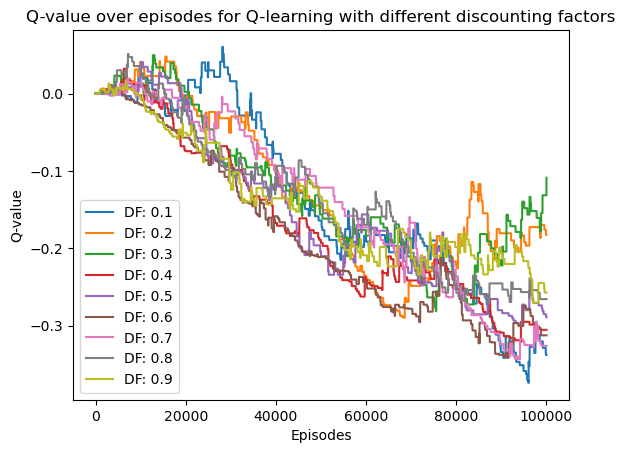

In [221]:
for i, discounting_factor in enumerate(discounting_factors):
    plt.plot(history_by_discounting_qlearning[i], label=f'DF: {discounting_factor:.1f}')
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with different discounting factors')
plt.legend()
plt.show()

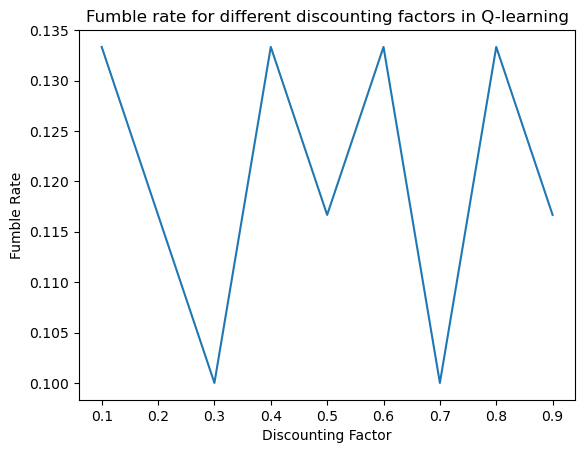

In [222]:
plt.plot(fumble_rate_by_discounting_qlearning)
plt.xlabel('Discounting Factor')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different discounting factors in Q-learning')
plt.xticks(range(len(discounting_factors)), [f'{df:.1f}' for df in discounting_factors])
plt.show()

In [223]:
# Same thing but change epsilon schedule to be 1/(i+1) for Q-learning
fumble_rate_by_discounting_qlearning_inv_time_epsilon = []
history_by_discounting_qlearning_inv_time_epsilon = []
for discounting_factor in discounting_factors:
    print(f'Discounting factor: {discounting_factor}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning, num_iters=num_iters, sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6, epsilon_schedule_update=simplest_schedule)

    fumble_rate_by_discounting_qlearning_inv_time_epsilon.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rate_by_discounting_qlearning_inv_time_epsilon[-1] * 100))
    # Train the model with the current discounting factor
    print("Training with discounting factor to get Q-value plot:", discounting_factor)
    policy, Q, history = qlearning(sample_step=sample_step_reward_negative_on_loss, prob_optimal=0.6, epsilon_schedule_update=simplest_schedule)
    history_by_discounting_qlearning_inv_time_epsilon.append(history)

Discounting factor: 0.1
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52023.05it/s]


Q values at start state: {(2, 2): -0.35039841061982846, (0, 2): -0.41597201495502084, (0, 3): -0.4122641070578477, (1, 3): -0.3442237930542171, (1, 2): -0.41728576049506616, (2, 3): -0.3093634312981903, (1, 1): -0.35084870126838463, (2, 1): -0.3795270751651783, (0, 1): -0.3926533958679893}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52595.79it/s]


Q values at start state: {(2, 3): -0.29829390852301974, (0, 3): -0.3657285864666007, (0, 1): -0.4224998386727713, (1, 3): -0.273085347525447, (1, 1): -0.4067158412949084, (2, 2): -0.3532519842105594, (2, 1): -0.4339788993756691, (0, 2): -0.41272793010700637, (1, 2): -0.4119417684214316}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52505.76it/s]


Q values at start state: {(1, 2): -0.3227717633683958, (0, 2): -0.41672495122012915, (1, 1): -0.4310590594706075, (0, 3): -0.3556984232605271, (1, 3): -0.3096467110443704, (0, 1): -0.45645315100052375, (2, 2): -0.3916757101798284, (2, 3): -0.3418859112322632, (2, 1): -0.3812883490622848}
Average number of fumbles: 2.0
Fumble rate: 10.00%
Training with discounting factor to get Q-value plot: 0.1


100%|██████████| 100000/100000 [00:01<00:00, 52419.31it/s]


Q values at start state: {(2, 1): -0.3897850871501436, (2, 3): -0.32443559653219306, (1, 2): -0.36056182804674897, (2, 2): -0.36279651016814557, (0, 3): -0.29645740235574275, (0, 2): -0.35874159199084626, (0, 1): -0.4268735305440249, (1, 3): -0.38852436110413013, (1, 1): -0.3404876167008183}
Discounting factor: 0.2
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52044.48it/s]


Q values at start state: {(2, 1): -0.36372231615334244, (0, 3): -0.21408297130038817, (1, 2): -0.37084994905559204, (0, 1): -0.48292854853423217, (0, 2): -0.4765890081542605, (1, 1): -0.39950872920701264, (2, 3): -0.3395082744756689, (1, 3): -0.43566831179913096, (2, 2): -0.39507494766797535}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 50396.37it/s]


Q values at start state: {(2, 3): -0.3650780765953815, (2, 2): -0.38788772685556594, (1, 3): -0.30207936737708324, (0, 3): -0.3532063734002886, (1, 1): -0.42194384118437406, (0, 2): -0.42964808322537634, (2, 1): -0.4042372641139276, (1, 2): -0.41883137571341106, (0, 1): -0.4621032788958342}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 50766.91it/s]


Q values at start state: {(0, 2): -0.49895468227154266, (1, 2): -0.3354483097516328, (2, 1): -0.4246077856576876, (2, 2): -0.341840224197712, (0, 3): -0.2797678113850441, (1, 3): -0.3121111346301821, (2, 3): -0.34342657443435554, (0, 1): -0.49659626382261896, (1, 1): -0.3769141622375502}
Average number of fumbles: 2.6666666666666665
Fumble rate: 13.33%
Training with discounting factor to get Q-value plot: 0.2


100%|██████████| 100000/100000 [00:01<00:00, 51581.94it/s]


Q values at start state: {(1, 2): -0.32561287225388535, (2, 1): -0.3995853723236717, (2, 3): -0.4013294488023341, (1, 3): -0.3878504093910394, (0, 3): -0.3648762455595211, (1, 1): -0.45140291822568906, (0, 1): -0.37798640439955744, (0, 2): -0.3241789184822672, (2, 2): -0.3669318876651144}
Discounting factor: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:02<00:00, 49954.30it/s]


Q values at start state: {(1, 3): -0.2802612239033079, (0, 2): -0.4017248104788266, (2, 2): -0.3657137866061082, (2, 3): -0.31976541106257783, (2, 1): -0.4313306566523103, (0, 3): -0.3003246019213495, (0, 1): -0.4320165421004921, (1, 1): -0.4226675968511821, (1, 2): -0.37163269695847234}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51612.88it/s]


Q values at start state: {(1, 2): -0.3380600244900248, (0, 3): -0.3644745694688207, (2, 3): -0.3470315232227723, (1, 3): -0.3989433387291766, (2, 2): -0.3697420226019897, (0, 1): -0.46874317200111404, (1, 1): -0.44912969963837857, (2, 1): -0.49544470609371405, (0, 2): -0.48599932536527}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 51402.99it/s]


Q values at start state: {(2, 1): -0.47793423913140004, (2, 2): -0.39034001957862996, (1, 2): -0.3441850785350667, (1, 3): -0.30255089601255836, (0, 1): -0.4234409354730778, (0, 3): -0.3823047437873549, (1, 1): -0.33300476848031646, (0, 2): -0.39244641052489443, (2, 3): -0.2932250355551189}
Average number of fumbles: 1.6666666666666667
Fumble rate: 8.33%
Training with discounting factor to get Q-value plot: 0.30000000000000004


100%|██████████| 100000/100000 [00:01<00:00, 51703.15it/s]


Q values at start state: {(1, 2): -0.3746354666469185, (0, 3): -0.3383296047504669, (2, 3): -0.312903233660502, (1, 3): -0.2931151598187351, (1, 1): -0.4132815908670283, (0, 1): -0.4531051334628975, (2, 1): -0.4761111069414313, (2, 2): -0.4190650804523869, (0, 2): -0.421409395129711}
Discounting factor: 0.4
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51904.67it/s]


Q values at start state: {(2, 2): -0.3943735503629635, (1, 1): -0.4418610786848516, (1, 2): -0.452637775201534, (0, 1): -0.47782861959489265, (0, 2): -0.47066955691559464, (2, 1): -0.4378712703695559, (1, 3): -0.3007326138793658, (2, 3): -0.34162978160782104, (0, 3): -0.39124605423653963}
iteration 2


100%|██████████| 100000/100000 [00:02<00:00, 49992.18it/s]


Q values at start state: {(0, 3): -0.34637437357870404, (2, 3): -0.36290773366320317, (2, 2): -0.3711584270780498, (2, 1): -0.3932466809936068, (1, 3): -0.339016072605896, (0, 1): -0.4775730673448796, (0, 2): -0.45044708345170703, (1, 1): -0.3946097857468898, (1, 2): -0.38318420214494114}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 51834.91it/s]


Q values at start state: {(1, 1): -0.42207023973880975, (1, 2): -0.3274587879032483, (0, 1): -0.428467004645256, (2, 1): -0.48230461431008764, (0, 2): -0.4985628096159677, (1, 3): -0.35484485338314825, (0, 3): -0.37040996571436935, (2, 3): -0.4499013741218559, (2, 2): -0.4145133443354193}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.4


100%|██████████| 100000/100000 [00:01<00:00, 51652.92it/s]


Q values at start state: {(1, 1): -0.44849829733752655, (1, 3): -0.21815106923793853, (1, 2): -0.34361592681701375, (2, 3): -0.3256956300721073, (2, 1): -0.38932132512252143, (0, 1): -0.45765223589241577, (0, 2): -0.4000414844495071, (2, 2): -0.37869590981223195, (0, 3): -0.31914859471339074}
Discounting factor: 0.5
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51766.53it/s]


Q values at start state: {(1, 2): -0.3696826017559818, (0, 2): -0.4641840239950768, (1, 1): -0.3883123894721228, (0, 3): -0.4111882957029095, (0, 1): -0.48396395890206223, (1, 3): -0.35224618888163856, (2, 2): -0.31198993952759224, (2, 1): -0.42140778070112717, (2, 3): -0.3882580133835802}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51519.54it/s]


Q values at start state: {(2, 3): -0.31049224930859154, (2, 1): -0.43990150076422013, (1, 3): -0.3411094637196668, (0, 1): -0.4290533774475009, (1, 2): -0.268058764387412, (2, 2): -0.4094831946941227, (0, 3): -0.37333194965471983, (1, 1): -0.4186125095199421, (0, 2): -0.4357127573308969}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 50166.47it/s]


Q values at start state: {(0, 1): -0.5134928122648482, (2, 2): -0.4427482201390773, (0, 3): -0.28744028376072683, (1, 1): -0.482228974161457, (1, 3): -0.2868079338965593, (2, 1): -0.40428649146490436, (1, 2): -0.3298605288691697, (2, 3): -0.24348265905381064, (0, 2): -0.5777445255683749}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.5


100%|██████████| 100000/100000 [00:01<00:00, 52134.11it/s]


Q values at start state: {(1, 2): -0.45622234560949115, (2, 2): -0.38765951360188405, (1, 3): -0.3815630992543112, (2, 3): -0.3562251625642914, (2, 1): -0.42752094109071875, (0, 3): -0.41199848854328885, (1, 1): -0.4338469201801702, (0, 1): -0.41882515113581004, (0, 2): -0.4311893917265031}
Discounting factor: 0.6
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52247.40it/s]


Q values at start state: {(1, 1): -0.4168825670096413, (2, 3): -0.36896060105460726, (0, 2): -0.46246646483649495, (1, 2): -0.4053817871941995, (2, 1): -0.4150696268505078, (0, 3): -0.3571026965052252, (2, 2): -0.368496830818138, (1, 3): -0.29039360590512225, (0, 1): -0.4832556846771224}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 52127.26it/s]


Q values at start state: {(1, 1): -0.3691436231509643, (0, 3): -0.37527395882564246, (1, 2): -0.3649671985595025, (2, 3): -0.27326563051822994, (1, 3): -0.2829868041333404, (2, 1): -0.4219690007813155, (2, 2): -0.3587332072223148, (0, 2): -0.4137932947878624, (0, 1): -0.47382227864063253}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52056.35it/s]


Q values at start state: {(2, 1): -0.41261953905209037, (1, 3): -0.4148565529576886, (1, 1): -0.38752990239413027, (2, 3): -0.37648042287468825, (1, 2): -0.3634668846069642, (0, 2): -0.39204229076548774, (0, 3): -0.37676884919253284, (0, 1): -0.39536210835276386, (2, 2): -0.3860823932786997}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.6


100%|██████████| 100000/100000 [00:01<00:00, 51084.55it/s]


Q values at start state: {(1, 2): -0.3299206810245321, (0, 2): -0.4597761485599653, (0, 1): -0.43369427701339924, (2, 1): -0.4630558978354505, (2, 3): -0.30730725943831394, (0, 3): -0.4225171623022865, (1, 3): -0.3216292092181984, (1, 1): -0.37655566238483656, (2, 2): -0.40802362093358413}
Discounting factor: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 52238.20it/s]


Q values at start state: {(2, 3): -0.3384846593873196, (1, 3): -0.38221450915860733, (0, 1): -0.47271259416017886, (2, 1): -0.4049622073935356, (0, 2): -0.5345503487049804, (1, 2): -0.3725641598336468, (2, 2): -0.4179356404489202, (1, 1): -0.35224389311985016, (0, 3): -0.32033124732050333}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51561.92it/s]


Q values at start state: {(2, 3): -0.32809772892641437, (1, 2): -0.4230028585442491, (1, 3): -0.3664687969958252, (2, 2): -0.36974278226126495, (0, 2): -0.43969881262541327, (0, 3): -0.29929992626123203, (1, 1): -0.33705558537325553, (2, 1): -0.3901253594229885, (0, 1): -0.45132567661374723}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52077.26it/s]


Q values at start state: {(0, 1): -0.4165726123913264, (1, 1): -0.440385595923703, (2, 3): -0.2941410807927093, (2, 1): -0.44075700976624665, (2, 2): -0.3442255353817167, (0, 2): -0.3827981385634948, (1, 2): -0.3858397270546805, (1, 3): -0.2750356039796267, (0, 3): -0.41810045990403416}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.7000000000000001


100%|██████████| 100000/100000 [00:01<00:00, 51331.01it/s]


Q values at start state: {(1, 3): -0.4222538720635565, (2, 3): -0.29666386797689676, (2, 1): -0.4382501528784447, (2, 2): -0.39093391366173147, (1, 2): -0.3732788963744925, (0, 3): -0.34956185450559313, (0, 1): -0.41363348247450776, (1, 1): -0.4130473134914543, (0, 2): -0.35339158655538183}
Discounting factor: 0.8
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51189.07it/s]


Q values at start state: {(2, 1): -0.4418008278477106, (0, 1): -0.4600973175800921, (2, 2): -0.4017031885112934, (1, 2): -0.3796773511009589, (1, 3): -0.34521288241348164, (0, 3): -0.31825345062298993, (0, 2): -0.4922622568545712, (2, 3): -0.23085493053556244, (1, 1): -0.4210198462472382}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51099.57it/s]


Q values at start state: {(1, 2): -0.3280581739279998, (0, 1): -0.3857731665677784, (1, 3): -0.37269112105198404, (2, 2): -0.3248828186890737, (2, 1): -0.4342754997130101, (1, 1): -0.4340461859816539, (0, 2): -0.38117189763655995, (2, 3): -0.37298125036373003, (0, 3): -0.3268680550984021}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 52293.98it/s]


Q values at start state: {(0, 3): -0.45381189745114375, (1, 3): -0.3482481728833499, (1, 2): -0.3182629779839951, (1, 1): -0.4152169441543071, (2, 2): -0.4016028663507198, (2, 1): -0.4361772399138277, (0, 1): -0.43454811247565656, (2, 3): -0.3053502891310258, (0, 2): -0.4375784111312181}
Average number of fumbles: 2.3333333333333335
Fumble rate: 11.67%
Training with discounting factor to get Q-value plot: 0.8


100%|██████████| 100000/100000 [00:01<00:00, 52173.00it/s]


Q values at start state: {(0, 3): -0.38412923217511113, (2, 2): -0.3638688844847908, (2, 3): -0.2747865812645442, (1, 3): -0.39842616459013097, (0, 1): -0.4084054493794391, (2, 1): -0.37194147869578903, (0, 2): -0.408436984136439, (1, 2): -0.234662298113757, (1, 1): -0.335995592764385}
Discounting factor: 0.9
iteration 1


100%|██████████| 100000/100000 [00:01<00:00, 51837.11it/s]


Q values at start state: {(2, 1): -0.35695274958551226, (0, 1): -0.4294625828333863, (0, 3): -0.3234626443081345, (1, 2): -0.3651883674925578, (2, 3): -0.23427234509311015, (1, 1): -0.39316850228445405, (0, 2): -0.42603875330836727, (1, 3): -0.35302896707922526, (2, 2): -0.37518820043660256}
iteration 2


100%|██████████| 100000/100000 [00:01<00:00, 51612.48it/s]


Q values at start state: {(2, 1): -0.38061704420145476, (1, 3): -0.3208339633306371, (0, 3): -0.41460761545923686, (1, 2): -0.40248805197166776, (0, 2): -0.3451322337533814, (2, 3): -0.29470330012986357, (2, 2): -0.4006879097746664, (0, 1): -0.4385655873699105, (1, 1): -0.407747984026055}
iteration 3


100%|██████████| 100000/100000 [00:01<00:00, 51401.52it/s]


Q values at start state: {(0, 1): -0.42897832586390355, (2, 1): -0.43379715189445833, (1, 3): -0.3103504833273389, (1, 1): -0.3919490190650187, (0, 2): -0.42876155780256026, (0, 3): -0.3372729045454059, (1, 2): -0.3563696007411647, (2, 3): -0.3507436084827199, (2, 2): -0.3562165811304855}
Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.9


100%|██████████| 100000/100000 [00:01<00:00, 51855.31it/s]

Q values at start state: {(1, 2): -0.36711300404735026, (0, 1): -0.45138843023769154, (2, 3): -0.3204749374535978, (0, 3): -0.37442804072564295, (2, 1): -0.4374412952626366, (2, 2): -0.40573258756192043, (1, 3): -0.3166881566691187, (0, 2): -0.480240958316001, (1, 1): -0.4396186478299337}


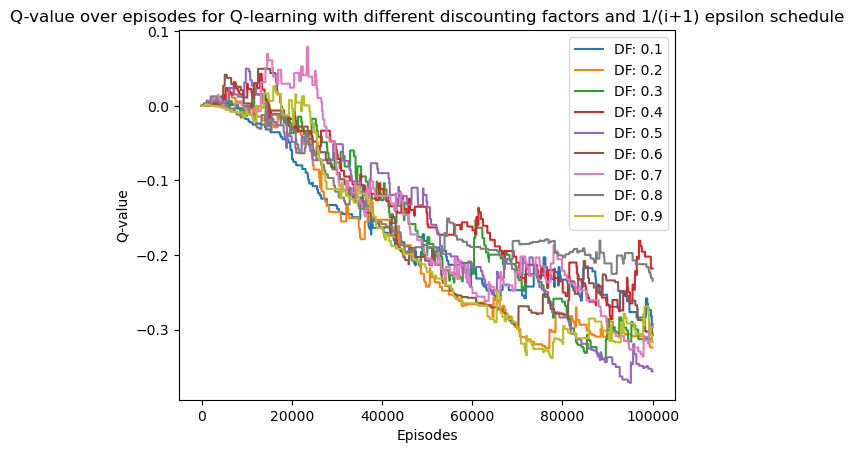

In [224]:
for i, discounting_factor in enumerate(discounting_factors):
    plt.plot(history_by_discounting_qlearning_inv_time_epsilon[i], label=f'DF: {discounting_factor:.1f}')
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Q-learning with different discounting factors and 1/(i+1) epsilon schedule')
plt.legend()
plt.show()

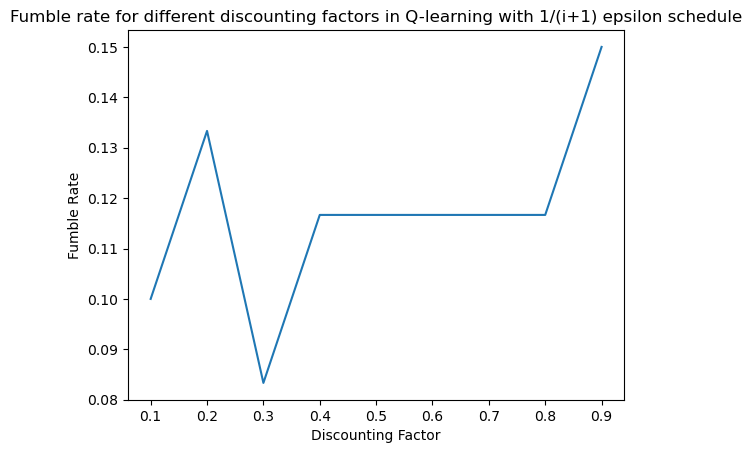

In [225]:
plt.plot(fumble_rate_by_discounting_qlearning_inv_time_epsilon)
plt.xlabel('Discounting Factor')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different discounting factors in Q-learning with 1/(i+1) epsilon schedule')
plt.xticks(range(len(discounting_factors)), [f'{df:.1f}' for df in discounting_factors])
plt.show()

In [226]:
# Evaluate the performance of the self-play Q-learning policy with respect to discounting factor
fumble_rate_by_discounting_self_play = []
history_by_discounting_self_play = []
for discounting_factor in discounting_factors:
    print(f'Discounting factor: {discounting_factor}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning_self_play, num_iters=num_iters, sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, epsilon_schedule=get_geometric_schedule(decay=0.3))

    fumble_rate_by_discounting_self_play.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rate_by_discounting_self_play[-1] * 100))
    # Train the model with the current discounting factor
    print("Training with discounting factor to get Q-value plot:", discounting_factor)
    policy, Q, history = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec)
    history_by_discounting_self_play.append(history)

Discounting factor: 0.1
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29628.70it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29198.37it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29276.08it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.1


100%|██████████| 100000/100000 [00:03<00:00, 28365.92it/s]


Discounting factor: 0.2
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29347.62it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 28640.01it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29210.84it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.2


100%|██████████| 100000/100000 [00:03<00:00, 29311.30it/s]


Discounting factor: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29694.67it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 28660.13it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29139.01it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.30000000000000004


100%|██████████| 100000/100000 [00:03<00:00, 28883.34it/s]


Discounting factor: 0.4
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29755.11it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 28701.01it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 28829.79it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.4


100%|██████████| 100000/100000 [00:03<00:00, 28880.88it/s]


Discounting factor: 0.5
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29771.41it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 28140.29it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 28766.53it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.5


100%|██████████| 100000/100000 [00:03<00:00, 27828.32it/s]


Discounting factor: 0.6
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 28243.78it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 27374.10it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 27947.93it/s]


Average number of fumbles: 3.3333333333333335
Fumble rate: 16.67%
Training with discounting factor to get Q-value plot: 0.6


100%|██████████| 100000/100000 [00:03<00:00, 27821.63it/s]


Discounting factor: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29126.67it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29471.42it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29768.60it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.7000000000000001


100%|██████████| 100000/100000 [00:03<00:00, 29482.81it/s]


Discounting factor: 0.8
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29682.45it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29351.75it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 28890.12it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.8


100%|██████████| 100000/100000 [00:03<00:00, 29262.90it/s]


Discounting factor: 0.9
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29150.60it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29849.34it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29969.33it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.9


100%|██████████| 100000/100000 [00:03<00:00, 29723.59it/s]


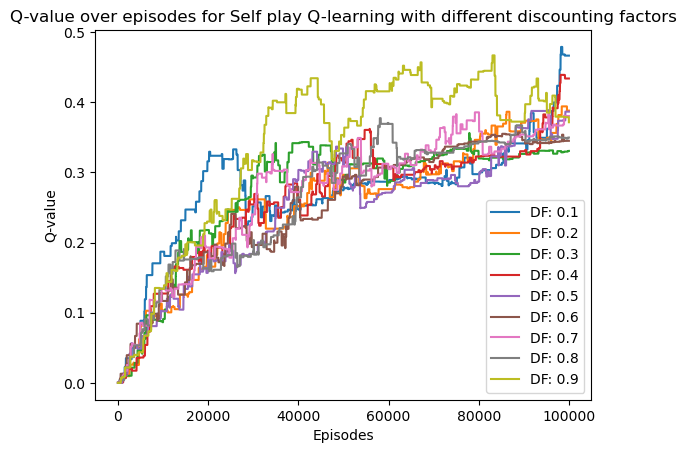

In [227]:
for i, discounting_factor in enumerate(discounting_factors):
    plt.plot(history_by_discounting_self_play[i], label=f'DF: {discounting_factor:.1f}')
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Self play Q-learning with different discounting factors')
plt.legend()
plt.show()

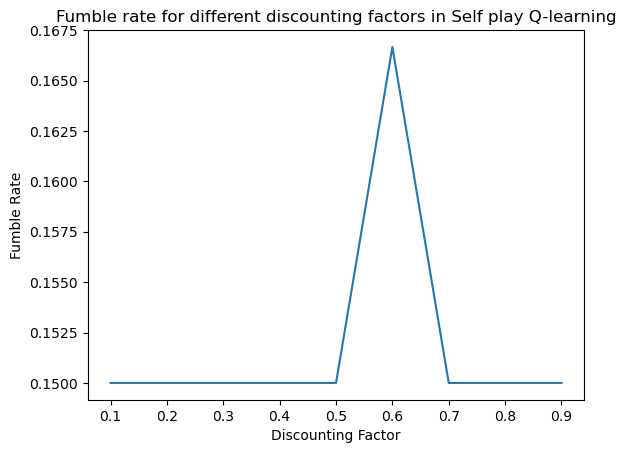

In [228]:
plt.plot(fumble_rate_by_discounting_self_play)
plt.xlabel('Discounting Factor')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different discounting factors in Self play Q-learning')
plt.xticks(range(len(discounting_factors)), [f'{df:.1f}' for df in discounting_factors])
plt.show()

In [229]:
# Evaluate the performance of the self-play Q-learning policy with respect to discounting factor
fumble_rate_by_discounting_self_play_with_mentor = []
history_by_discounting_self_play_with_mentor = []
for discounting_factor in discounting_factors:
    print(f'Discounting factor: {discounting_factor}')
    num_iters = 3
    total_fumbles, num_winning_pos = evaluate_using_fumbles_averaged(qlearning_self_play, num_iters=num_iters, sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec, play_against_optimal_until=10000, epsilon_schedule=get_geometric_schedule(decay=0.3))

    fumble_rate_by_discounting_self_play_with_mentor.append(float(total_fumbles) / float(num_winning_pos * num_iters))
    print('Average number of fumbles:', total_fumbles / num_iters)
    print('Fumble rate: {:.2f}%'.format(fumble_rate_by_discounting_self_play_with_mentor[-1] * 100))
    # Train the model with the current discounting factor
    print("Training with discounting factor to get Q-value plot:", discounting_factor)
    policy, Q, history = qlearning_self_play(sample_step=sample_step_reward_negative_on_loss_self_play_unless_spec)
    history_by_discounting_self_play_with_mentor.append(history)

Discounting factor: 0.1
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29247.27it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29652.05it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 30000.84it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.1


100%|██████████| 100000/100000 [00:03<00:00, 30132.74it/s]


Discounting factor: 0.2
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29760.12it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29894.03it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29838.61it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.2


100%|██████████| 100000/100000 [00:03<00:00, 29465.46it/s]


Discounting factor: 0.30000000000000004
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 30079.00it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29548.69it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29889.37it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.30000000000000004


100%|██████████| 100000/100000 [00:03<00:00, 29830.15it/s]


Discounting factor: 0.4
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29474.82it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 30018.88it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29339.16it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.4


100%|██████████| 100000/100000 [00:03<00:00, 29689.35it/s]


Discounting factor: 0.5
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29606.59it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29045.32it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29408.52it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.5


100%|██████████| 100000/100000 [00:03<00:00, 28469.96it/s]


Discounting factor: 0.6
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29118.17it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29943.41it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29844.62it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.6


100%|██████████| 100000/100000 [00:03<00:00, 29131.71it/s]


Discounting factor: 0.7000000000000001
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29689.85it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 30168.77it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29470.45it/s]


Average number of fumbles: 3.3333333333333335
Fumble rate: 16.67%
Training with discounting factor to get Q-value plot: 0.7000000000000001


100%|██████████| 100000/100000 [00:03<00:00, 28902.69it/s]


Discounting factor: 0.8
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 28808.95it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29439.18it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 29631.29it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.8


100%|██████████| 100000/100000 [00:03<00:00, 29041.46it/s]


Discounting factor: 0.9
iteration 1


100%|██████████| 100000/100000 [00:03<00:00, 29598.88it/s]


iteration 2


100%|██████████| 100000/100000 [00:03<00:00, 29499.83it/s]


iteration 3


100%|██████████| 100000/100000 [00:03<00:00, 30261.16it/s]


Average number of fumbles: 3.0
Fumble rate: 15.00%
Training with discounting factor to get Q-value plot: 0.9


100%|██████████| 100000/100000 [00:03<00:00, 29200.11it/s]


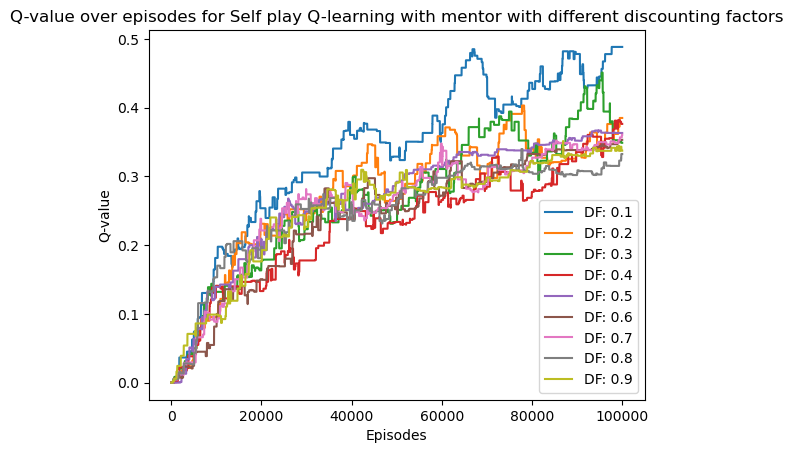

In [230]:
for i, discounting_factor in enumerate(discounting_factors):
    plt.plot(history_by_discounting_self_play_with_mentor[i], label=f'DF: {discounting_factor:.1f}')
plt.xlabel('Episodes')
plt.ylabel('Q-value')
plt.title('Q-value over episodes for Self play Q-learning with mentor with different discounting factors')
plt.legend()
plt.show()

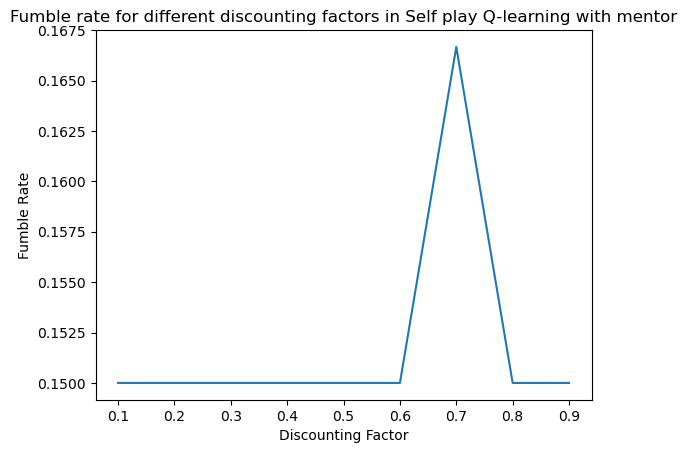

In [231]:
plt.plot(fumble_rate_by_discounting_self_play_with_mentor)
plt.xlabel('Discounting Factor')
plt.ylabel('Fumble Rate')
plt.title('Fumble rate for different discounting factors in Self play Q-learning with mentor')
plt.xticks(range(len(discounting_factors)), [f'{df:.1f}' for df in discounting_factors])
plt.show()